In [3]:
# Importing Libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For statistical methods
import scipy.stats as stats

# For Transforming categorical variables
from sklearn.preprocessing import LabelEncoder

# For splitting the dataset
from sklearn.model_selection import train_test_split, cross_val_score

# For scaling
from sklearn.preprocessing import StandardScaler

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Bayesian Optimization
# !pip3 install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Report
from sklearn.metrics import f1_score, make_scorer, classification_report

# Handle Warning
import warnings
warnings.filterwarnings('ignore')

In [4]:
path = os.path.join(r"C:\Users\vaibh\Documents\JobIntern\Projects\EcommerceOrdersSupply\Code\modified1.csv")
df = pd.read_csv(path)
print(df.shape)
df.head(2)

(87413, 21)


,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,product_id,seller_id,price,shipping_charges,...,customer_city,customer_state,product_category_name,product_weight_g,payment_sequential,payment_type,payment_installments,payment_value,is_late,product_volume
0,Axfy13Hk4PIk,hCT0x9JiGXBQ,2017-10-22 18:57:54,2017-10-22 19:14:13,2017-10-26 22:19:52,2017-11-09,90K0C1fIyQUf,ZWM05J9LcBSF,223.51,84.65,...,varzea paulista,SP,toys,491.0,1,credit_card,1,259.14,0,3648.0
1,v6px92oS8cLG,PxA7fv9spyhx,2018-06-20 21:40:31,2018-06-20 22:20:20,2018-07-03 22:51:22,2018-07-24,qejhpMGGVcsl,IjlpYfhUbRQs,170.80,23.79,...,armacao dos buzios,RJ,watches_gifts,440.0,1,credit_card,8,382.39,0,4284.0


In [5]:
df['is_late'].value_counts()

is_late
0    80676
1     6737
Name: count, dtype: int64

In [6]:
# Changing datatypes of 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_timestamp', 'order_estimated_delivery_date'
df[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_timestamp', 'order_estimated_delivery_date']] = df[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_timestamp', 'order_estimated_delivery_date']].apply(pd.to_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87413 entries, 0 to 87412
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       87413 non-null  object        
 1   customer_id                    87413 non-null  object        
 2   order_purchase_timestamp       87413 non-null  datetime64[ns]
 3   order_approved_at              87413 non-null  datetime64[ns]
 4   order_delivered_timestamp      87413 non-null  datetime64[ns]
 5   order_estimated_delivery_date  87413 non-null  datetime64[ns]
 6   product_id                     87413 non-null  object        
 7   seller_id                      87413 non-null  object        
 8   price                          87413 non-null  float64       
 9   shipping_charges               87413 non-null  float64       
 10  customer_zip_code_prefix       87413 non-null  int64         
 11  customer_city  

* Predefined Functions for Plotting

In [7]:
def create_overlay_barplot(df, categories):
    
    fig, axs = plt.subplots(len(categories)//2 + len(categories)%2, 2 if len(categories)>1 else 1,
                            figsize=(26, 5*(len(categories)//2+1)))

    for i, variable in enumerate(categories):
        df_temp = df[[variable, 'is_late']].groupby(variable).agg(
            is_late=('is_late', 'sum'),
            count=(variable, 'size')
        ).reset_index()
        df_temp['percentage'] = (df_temp['is_late']/df_temp['count'])*100
        df_temp = df_temp.sort_values(by='is_late', ascending=False)
        
        sns.barplot(df_temp, x=variable, y='count', color='lightblue', ax=axs[i//2, i%2], label='Total Count')
        sns.barplot(df_temp, x=variable, y='is_late', color='blue', ax=axs[i//2, i%2], label='Late Count')
        
        for index, row in df_temp.iterrows():
            axs[i//2, i%2].text(
                x=index, 
                y=row['is_late'] + 0.02 * max(df_temp['count']),  # Positioning above the bar
                s=f"{row['percentage']:.1f}%", 
                ha='center', va='bottom', color='black', fontsize=10
            )
        
        axs[i//2, i%2].set_title(f'Plot for {variable.upper()} with Percentage')
        axs[i//2, i%2].set_xlabel(variable)
        axs[i//2, i%2].set_ylabel('count')
        axs[i//2, i%2].legend(loc='upper left')
        del df_temp

    plt.tight_layout()
    plt.show()

## Exploratory Data Analysis

### 1. Order Purchase Timestamp

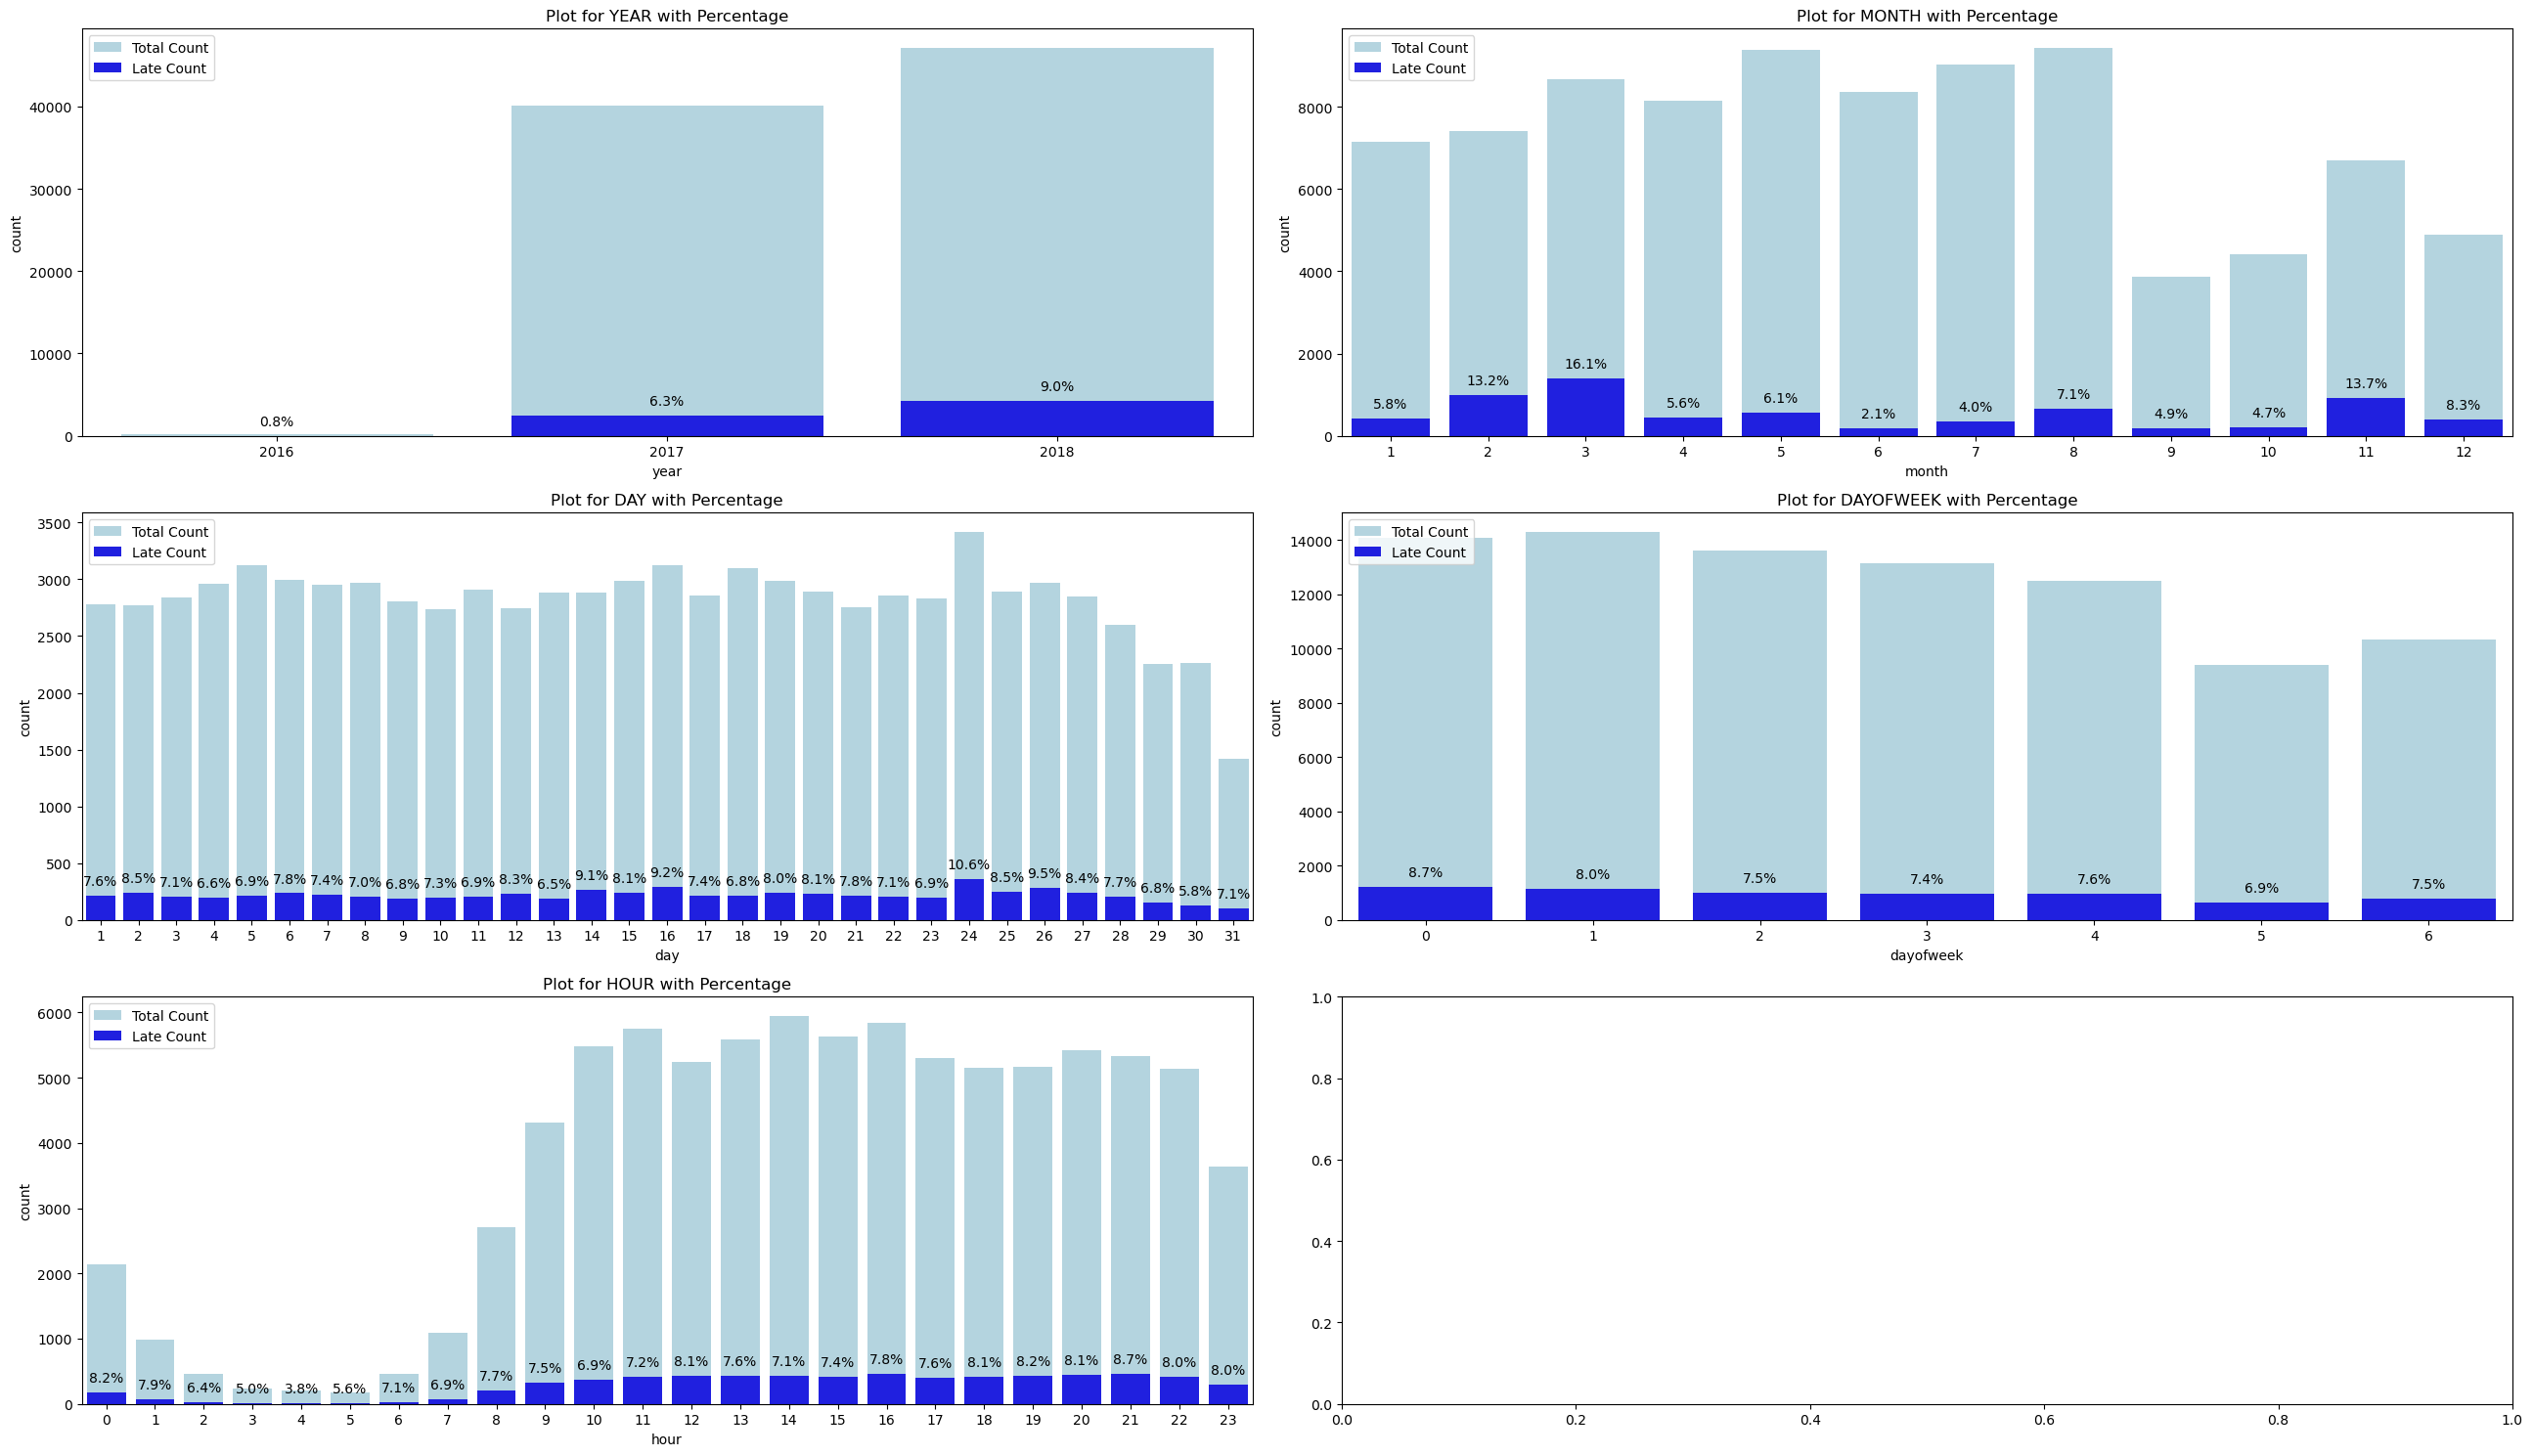

In [8]:
cats = ['year', 'month', 'day', 'dayofweek', 'hour']
df_tmp = df[['order_purchase_timestamp', 'is_late']]

for cat in cats:
    df_tmp[cat] = getattr(df['order_purchase_timestamp'].dt, cat).rename(cat)
    
df_tmp = df_tmp.drop(columns=['order_purchase_timestamp'])

create_overlay_barplot(df_tmp, cats)

* Observation -
1. The purchase datetime features does not provide any clear distinction btw late deliveries and normal deliveries
2. However, Purchase Month and Hour have some differenced in the late counts

### 2. Order Approval Timestamp

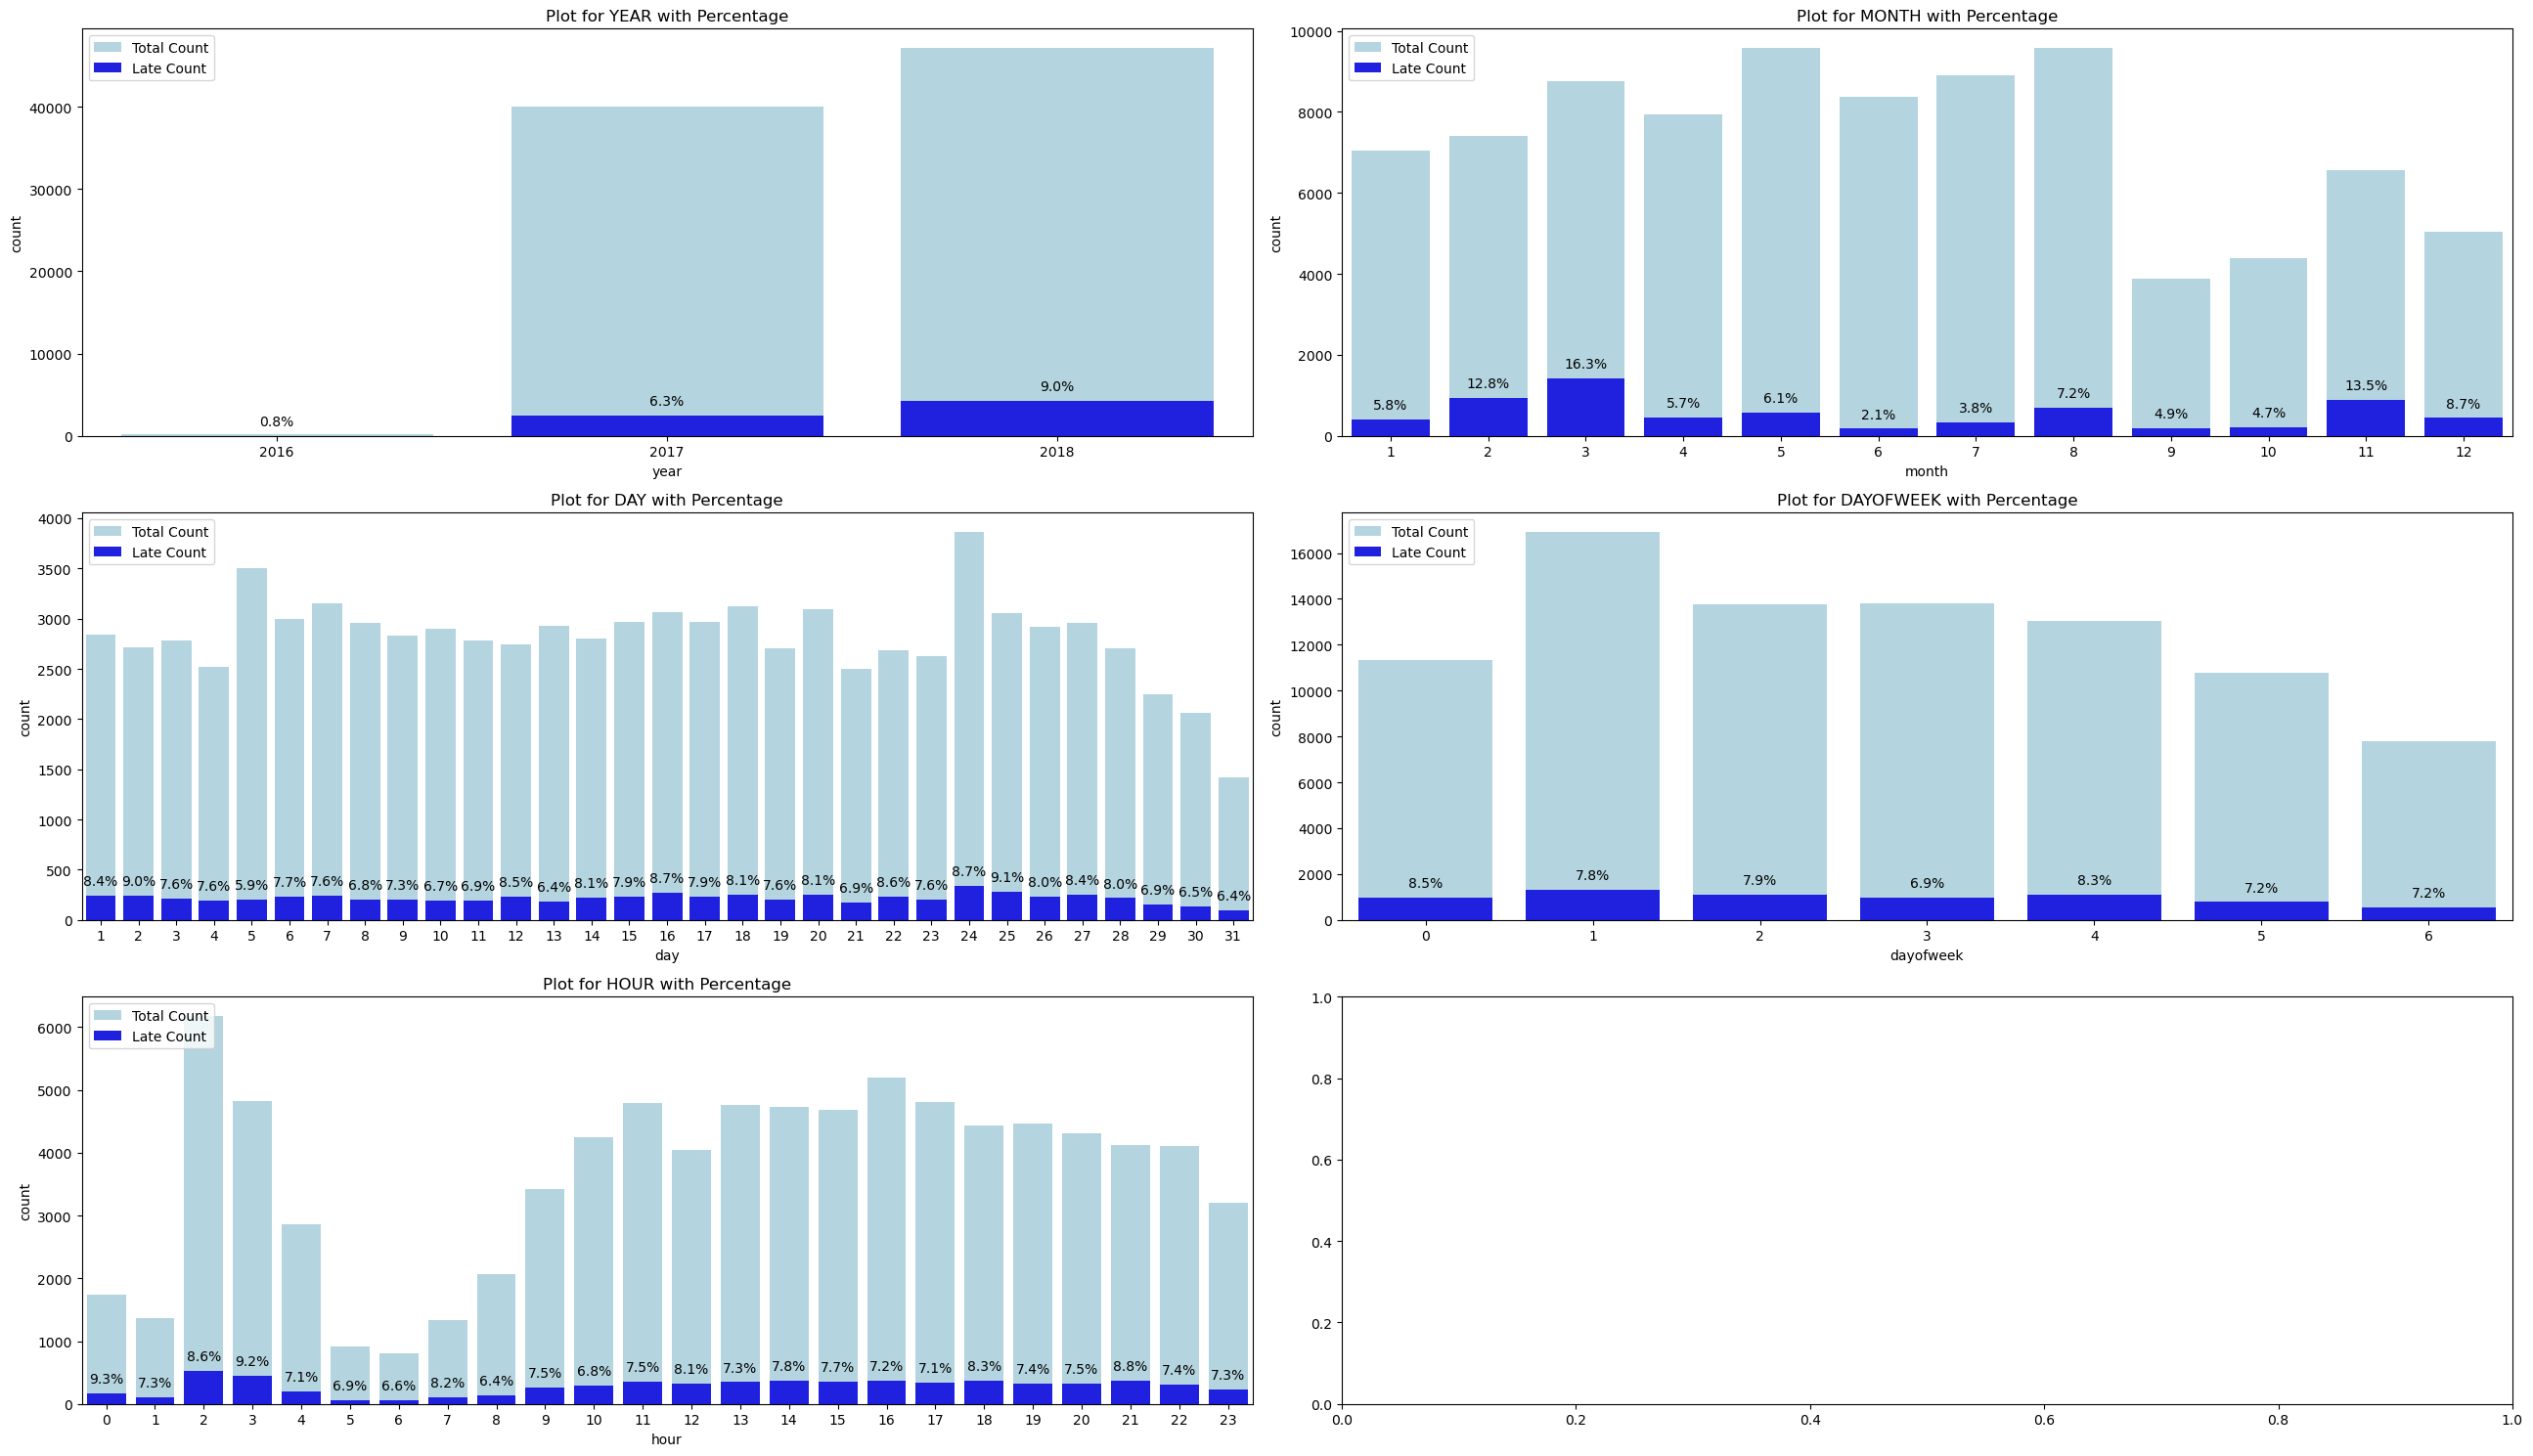

In [9]:
cats = ['year', 'month', 'day', 'dayofweek', 'hour']
df_tmp = df[['order_approved_at', 'is_late']]

for cat in cats:
    df_tmp[cat] = getattr(df['order_approved_at'].dt, cat).rename(cat)
    
df_tmp = df_tmp.drop(columns=['order_approved_at'])

create_overlay_barplot(df_tmp, cats)

* Observation - 
1. Similar to Purchase datatime features - datetime features of 'order_approved_at' does not provide clear distinction btw normal and late deliveries
2. However, Month and hour have some diff

### 3. Order Delivery Timestamp

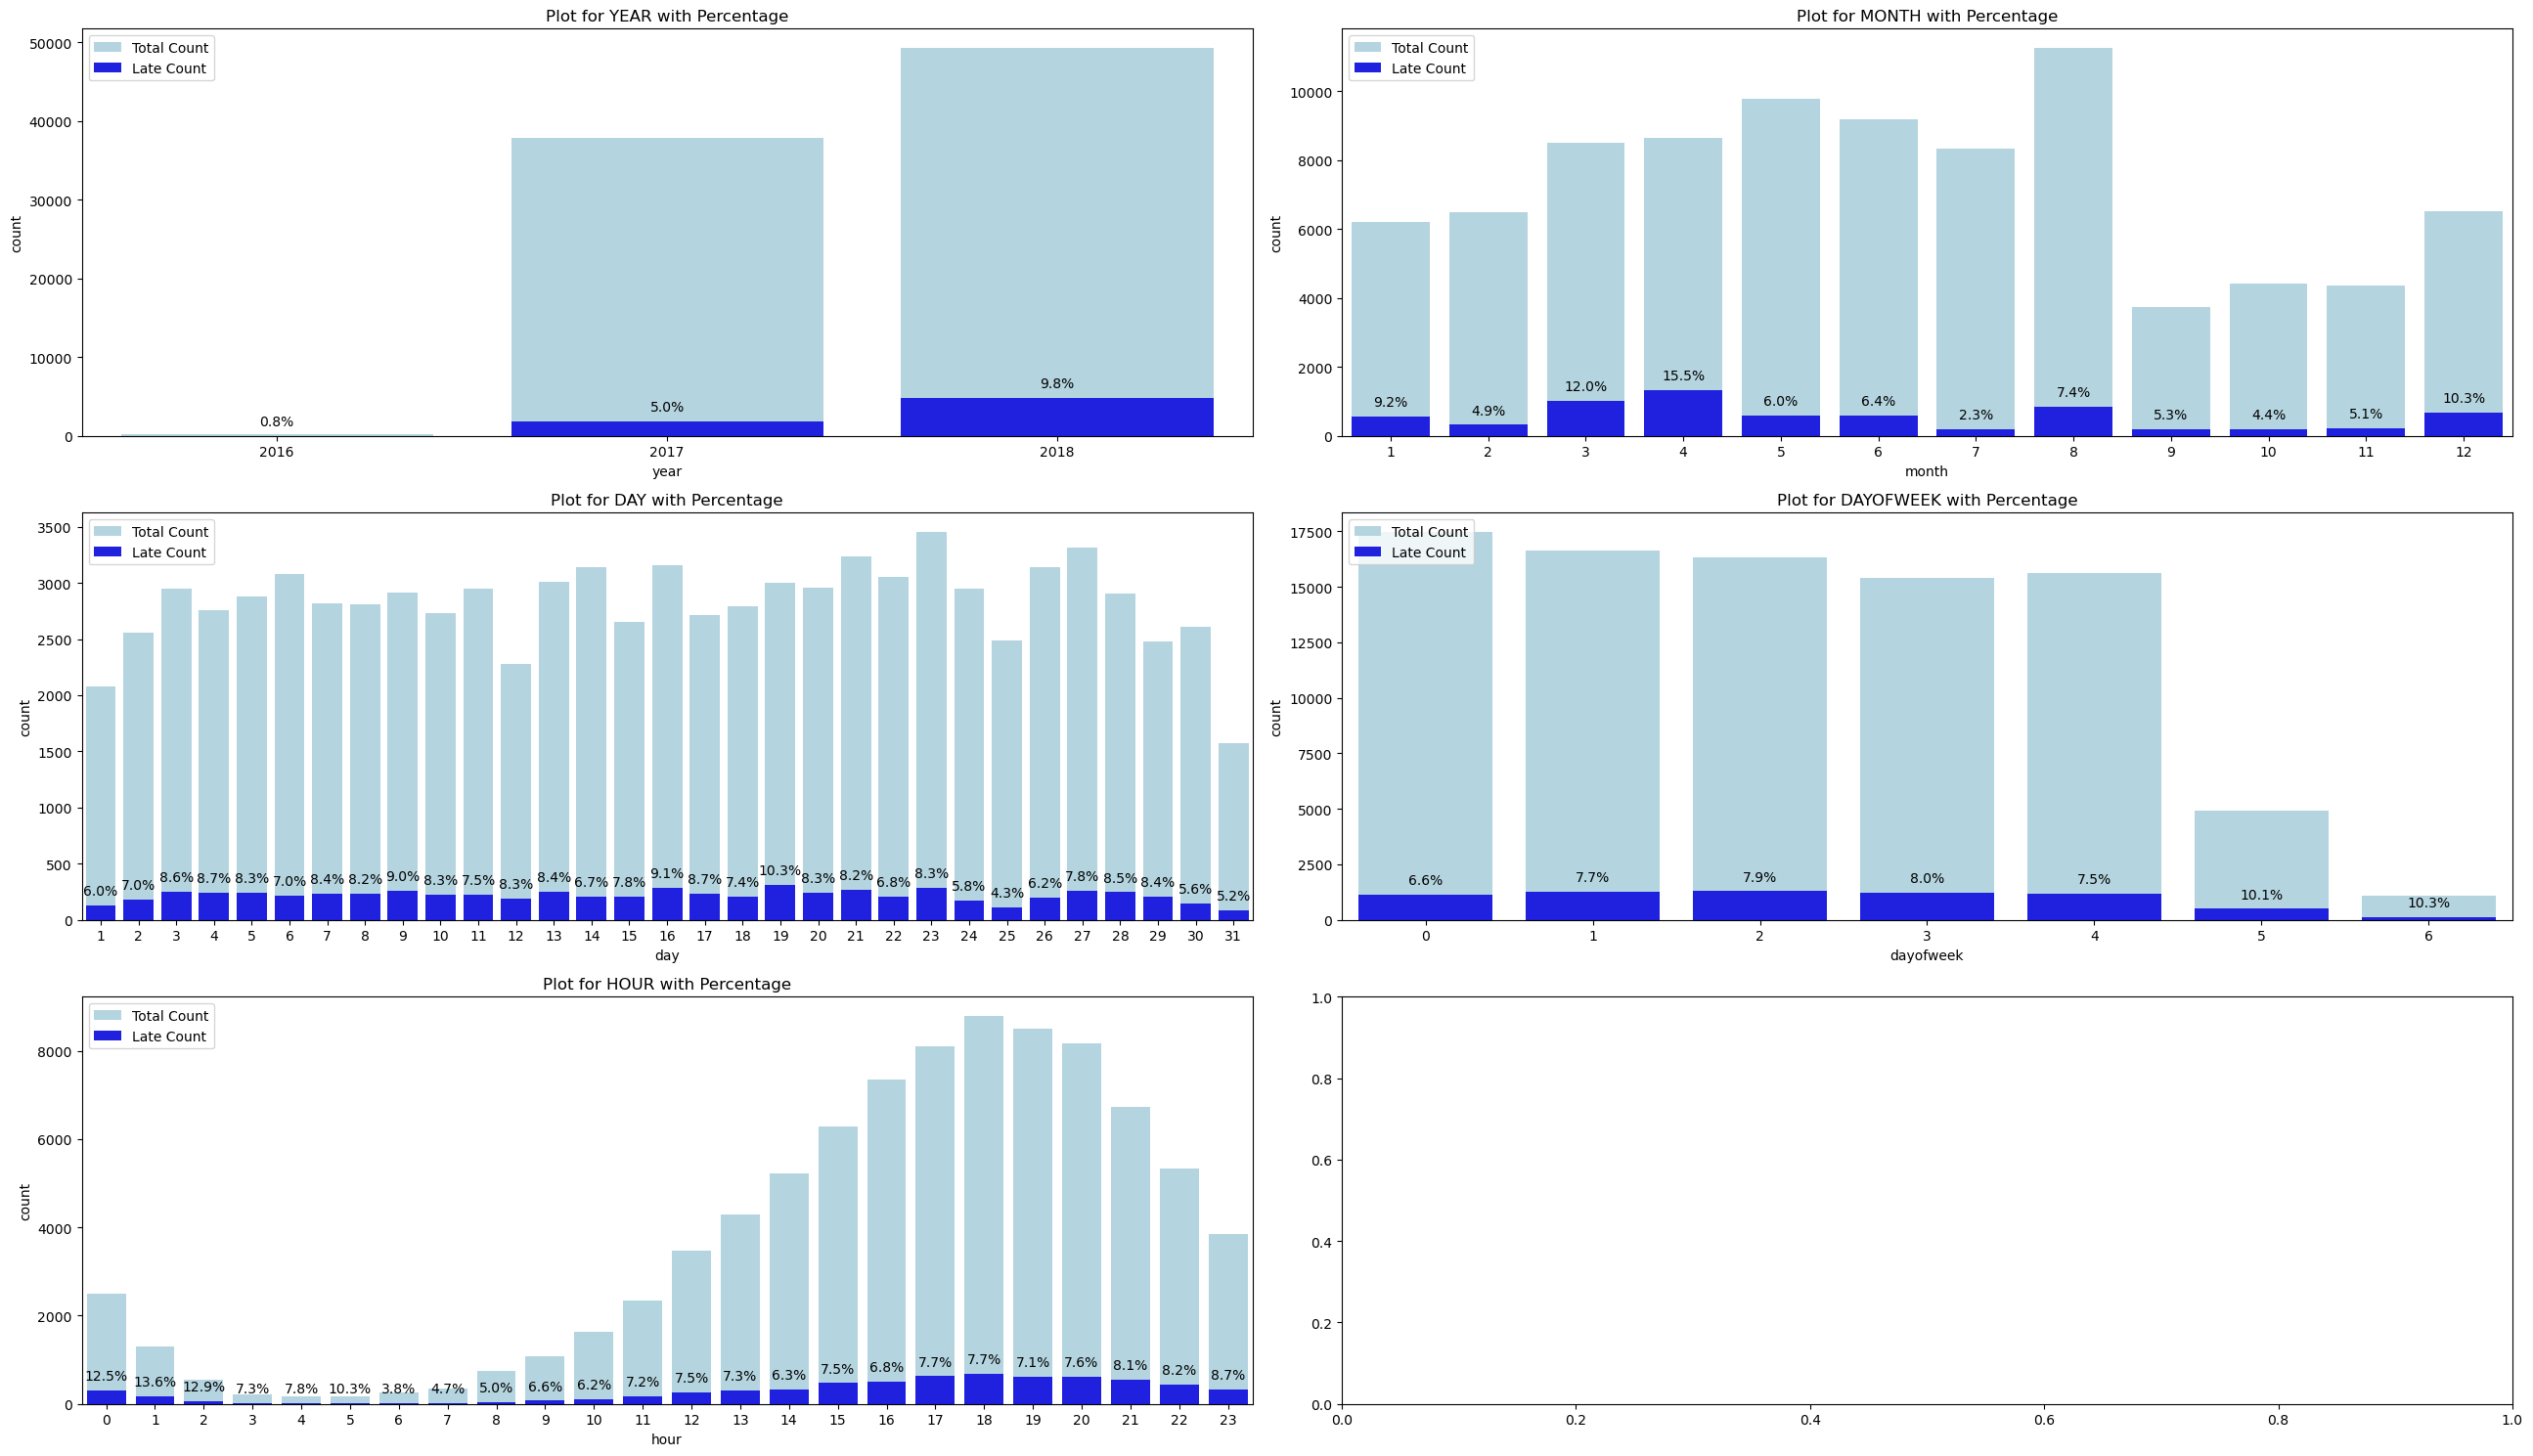

In [10]:
cats = ['year', 'month', 'day', 'dayofweek', 'hour']
df_tmp = df[['order_delivered_timestamp', 'is_late']]

for cat in cats:
    df_tmp[cat] = getattr(df['order_delivered_timestamp'].dt, cat).rename(cat)
    
df_tmp = df_tmp.drop(columns=['order_delivered_timestamp'])

create_overlay_barplot(df_tmp, cats)

* Observation - 
1. Month, hour and day of week have some differences in late counts

### 4. Order Estimated Timestamp

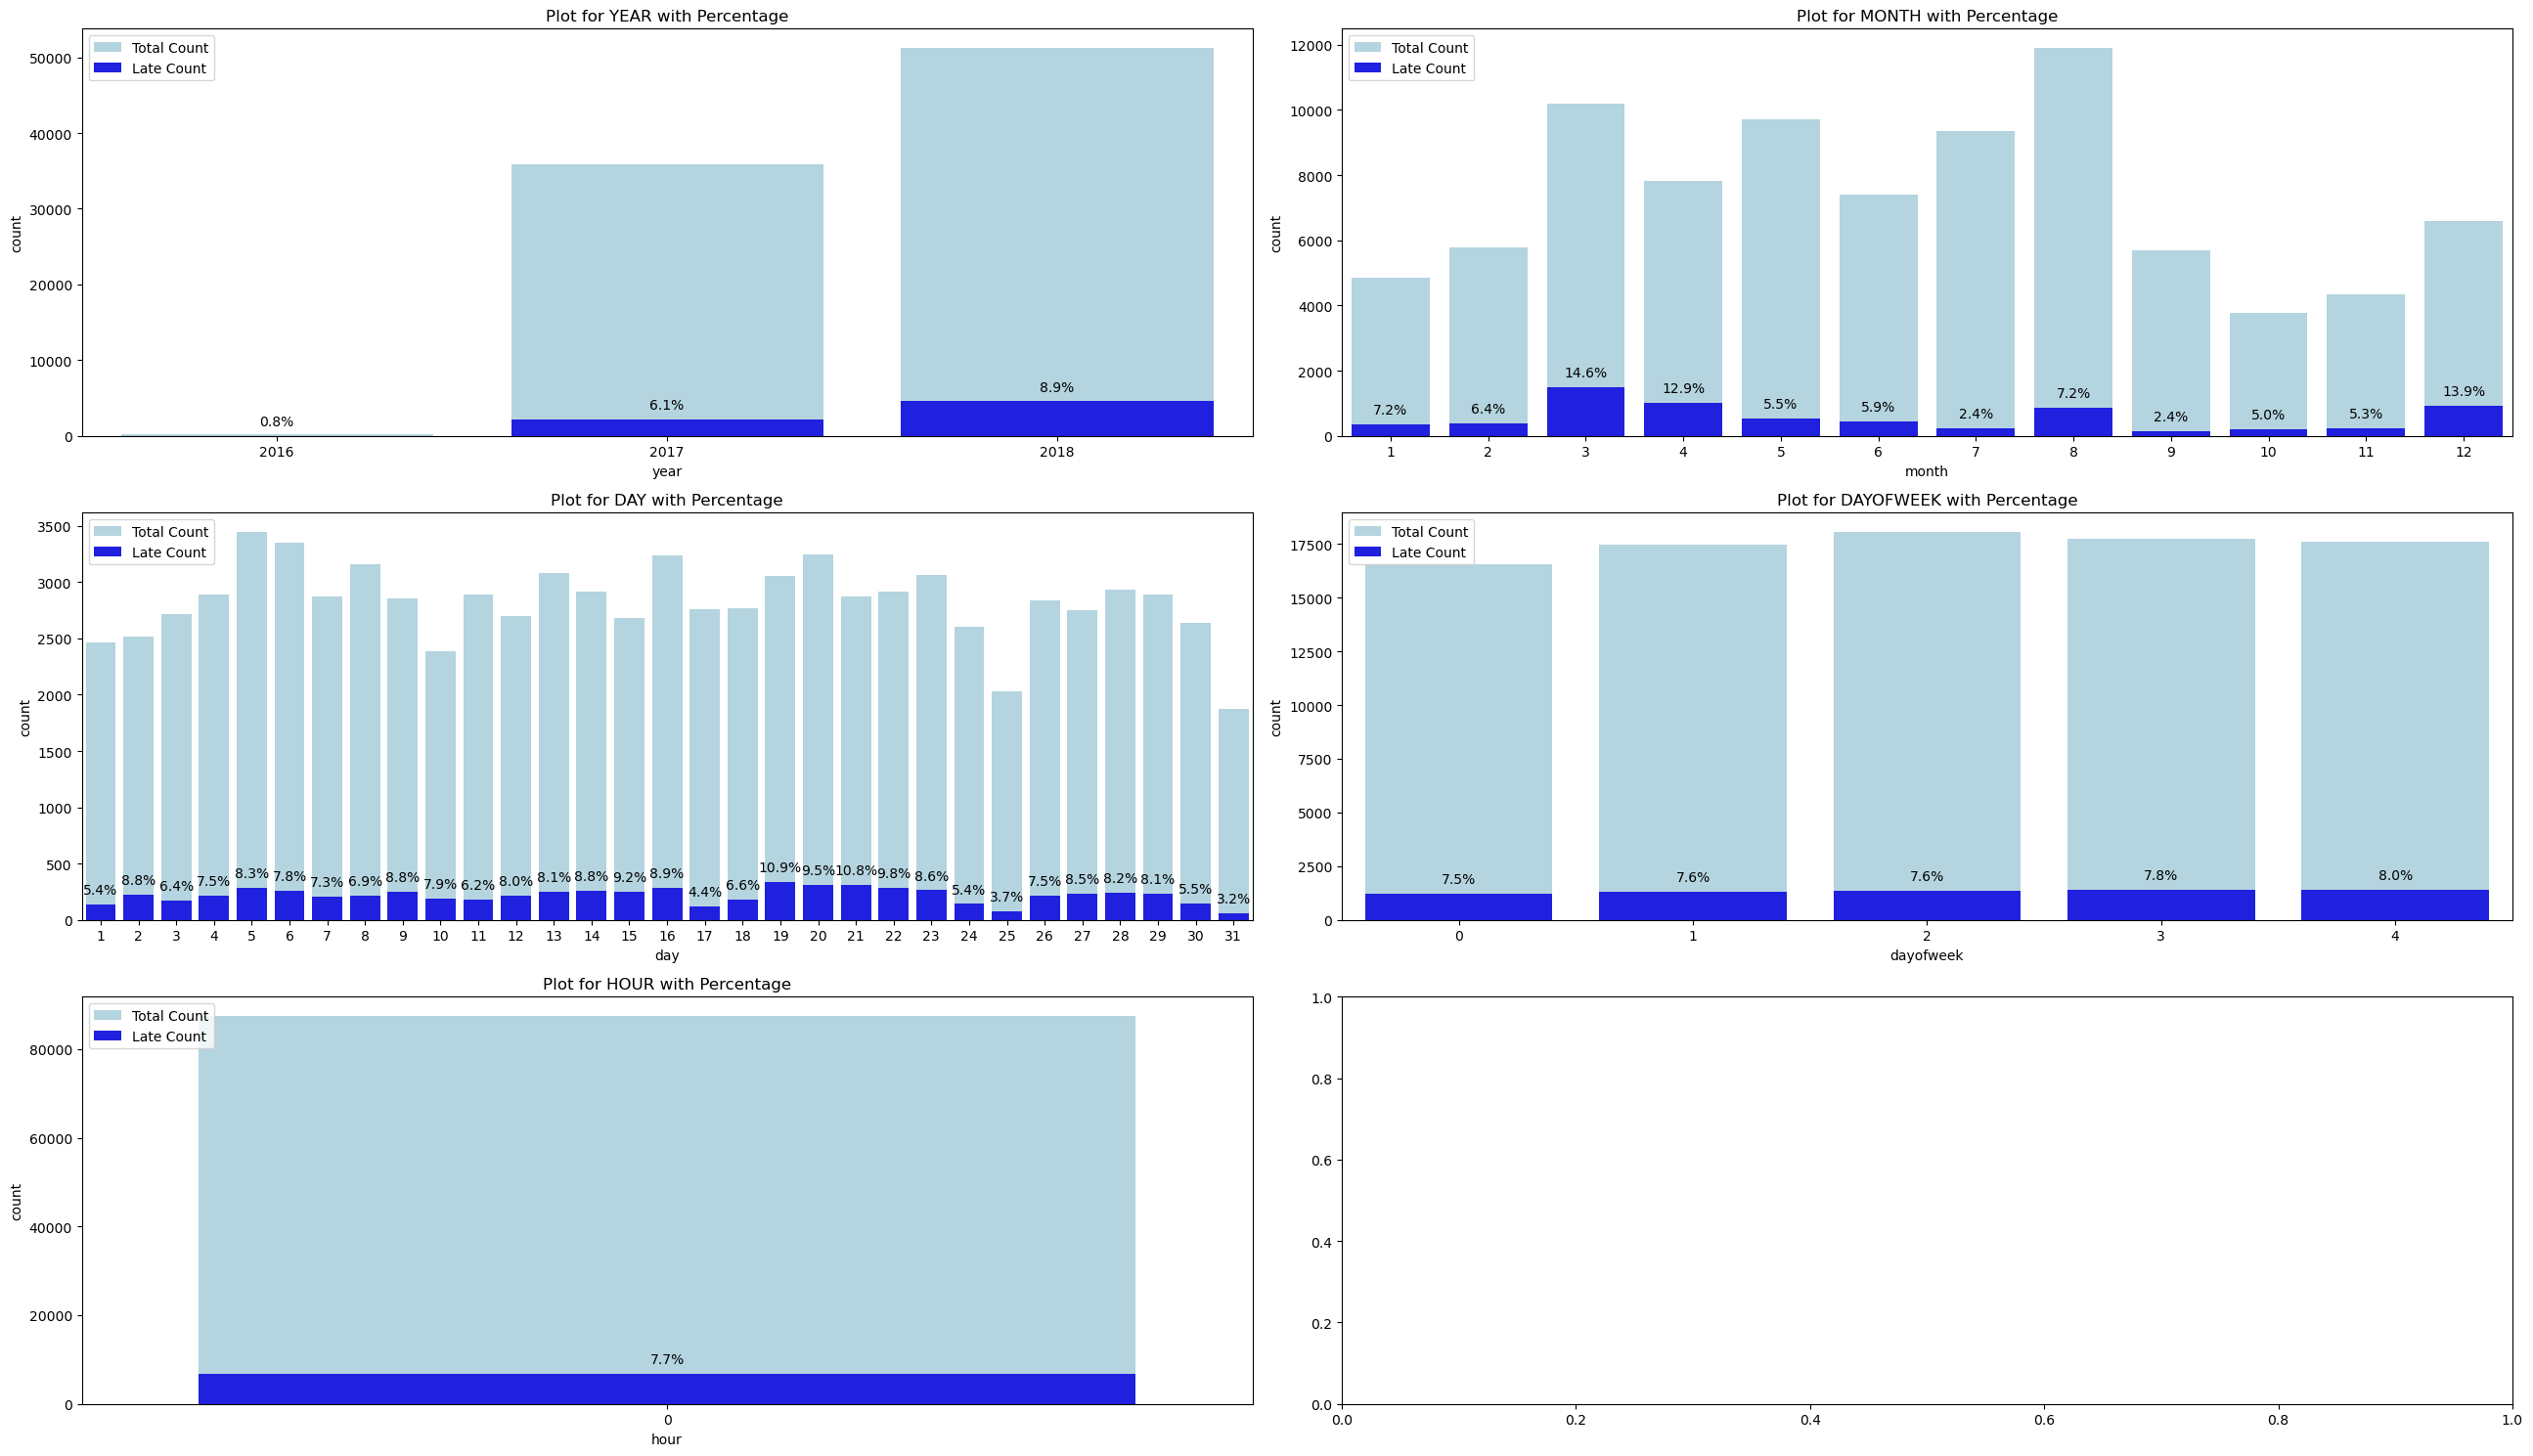

In [11]:
cats = ['year', 'month', 'day', 'dayofweek', 'hour']
df_tmp = df[['order_estimated_delivery_date', 'is_late']]

for cat in cats:
    df_tmp[cat] = getattr(df['order_estimated_delivery_date'].dt, cat).rename(cat)
    
df_tmp = df_tmp.drop(columns=['order_estimated_delivery_date'])

create_overlay_barplot(df_tmp, cats)

* Observations - 
1. None of the datetime columns have a significant effect on predicting whether an order will be delivered late
2. However, the diff btw the order approved and order estimated delivery date could give us some important feature - bcz the delay is likely is this diff is large

### 4(a). Diff Btw Order Apporved and Order Estimated delivery time

In [12]:
df['delta_t'] = df['order_estimated_delivery_date'] - df['order_approved_at']
df['delta_t'] = pd.to_timedelta(df['delta_t'])
df['approve_estimated_diff'] = df['delta_t'].dt.total_seconds()/(24*3600)
df = df.drop(columns=['delta_t'])
df.head(2)

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,product_id,seller_id,price,shipping_charges,...,customer_state,product_category_name,product_weight_g,payment_sequential,payment_type,payment_installments,payment_value,is_late,product_volume,approve_estimated_diff
0,Axfy13Hk4PIk,hCT0x9JiGXBQ,2017-10-22 18:57:54,2017-10-22 19:14:13,2017-10-26 22:19:52,2017-11-09,90K0C1fIyQUf,ZWM05J9LcBSF,223.51,84.65,...,SP,toys,491.0,1,credit_card,1,259.14,0,3648.0,17.198461
1,v6px92oS8cLG,PxA7fv9spyhx,2018-06-20 21:40:31,2018-06-20 22:20:20,2018-07-03 22:51:22,2018-07-24,qejhpMGGVcsl,IjlpYfhUbRQs,170.80,23.79,...,RJ,watches_gifts,440.0,1,credit_card,8,382.39,0,4284.0,33.069213


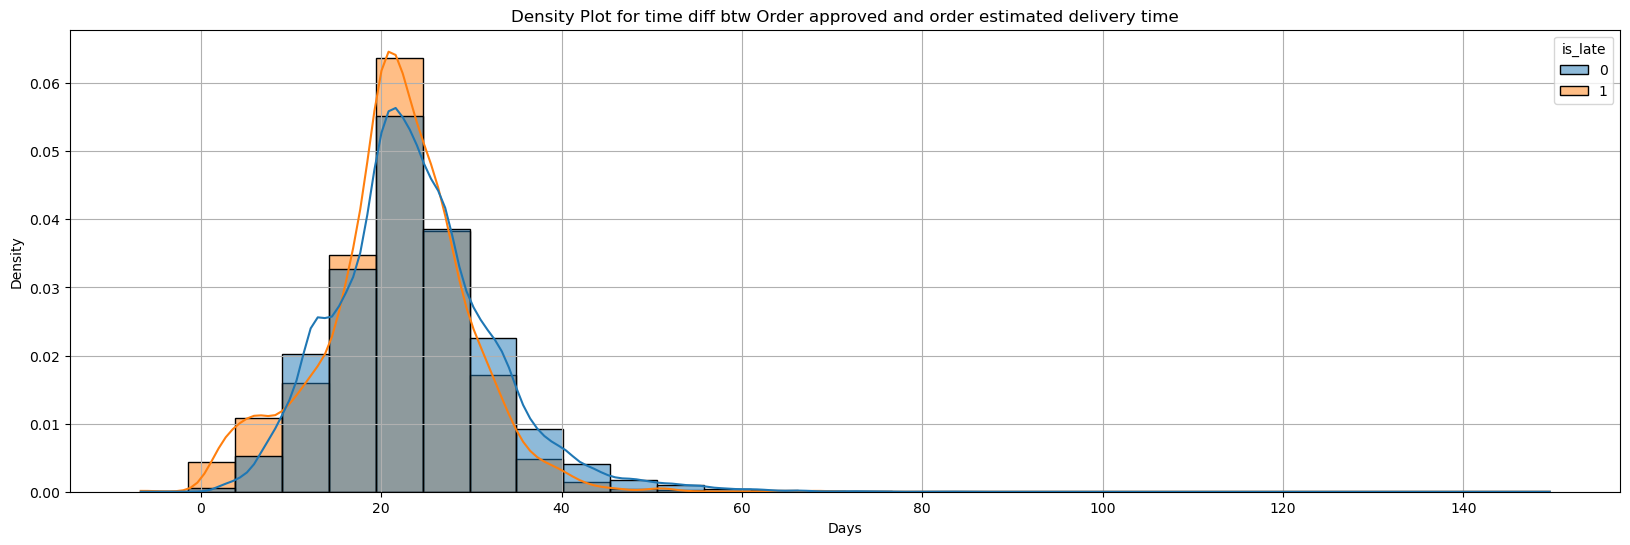

In [13]:
# Plotting histogram with density
plt.figure(figsize=(20, 6))
sns.histplot(data=df, x='approve_estimated_diff', hue='is_late', kde=True, stat="density", common_norm=False, bins=30)
plt.xlabel('Days')
plt.ylabel('Density')
plt.title('Density Plot for time diff btw Order approved and order estimated delivery time')
plt.grid(True)
plt.show()

### 4(b). Diff Btw Order Purchased and Order Approved

In [14]:
df['delta_t'] = df['order_approved_at'] - df['order_purchase_timestamp']
df['delta_t'] = pd.to_timedelta(df['delta_t'])
df['purchase_approve_diff'] = df['delta_t'].dt.total_seconds()/(24*3600)
df = df.drop(columns=['delta_t'])
df.head(2)

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,product_id,seller_id,price,shipping_charges,...,product_category_name,product_weight_g,payment_sequential,payment_type,payment_installments,payment_value,is_late,product_volume,approve_estimated_diff,purchase_approve_diff
0,Axfy13Hk4PIk,hCT0x9JiGXBQ,2017-10-22 18:57:54,2017-10-22 19:14:13,2017-10-26 22:19:52,2017-11-09,90K0C1fIyQUf,ZWM05J9LcBSF,223.51,84.65,...,toys,491.0,1,credit_card,1,259.14,0,3648.0,17.198461,0.011331
1,v6px92oS8cLG,PxA7fv9spyhx,2018-06-20 21:40:31,2018-06-20 22:20:20,2018-07-03 22:51:22,2018-07-24,qejhpMGGVcsl,IjlpYfhUbRQs,170.80,23.79,...,watches_gifts,440.0,1,credit_card,8,382.39,0,4284.0,33.069213,0.027650


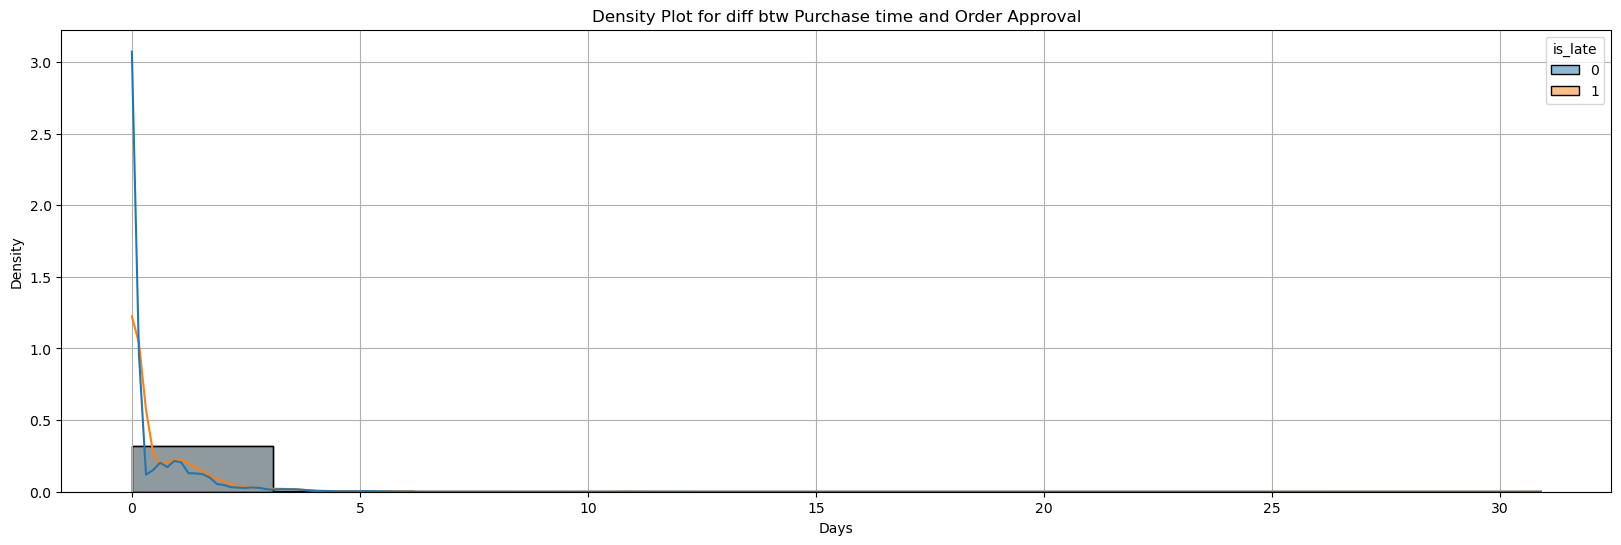

In [15]:
# Plotting histogram with density
plt.figure(figsize=(20, 6))
sns.histplot(data=df, x='purchase_approve_diff', hue='is_late', kde=True, stat="density", common_norm=False, bins=10)
plt.xlabel('Days')
plt.ylabel('Density')
plt.title('Density Plot for diff btw Purchase time and Order Approval')
plt.grid(True)
plt.show()

* Observations - 
1. The features derived from the time difference offer minimal distinction in predicting whether an order will be late or not.

### 5. Seller Id

In [16]:
tmp = df[['seller_id', 'is_late']].groupby('seller_id').agg(
    is_late=('is_late','sum'),
    count=('seller_id','size')
)
tmp['percent'] = (tmp['is_late']/tmp['count'])*100
tmp = tmp.sort_values(by=['is_late', 'percent'], ascending=[False, False]).reset_index()
print(tmp.shape)
tmp = pd.concat([tmp.head(10), tmp.tail(10)], ignore_index=True)
tmp.head()

(2822, 4)


,seller_id,is_late,count,percent
0,RKad98cTxhSb,168,1624,10.344828
1,r7VxefoTVHbb,147,1512,9.722222
2,coi9xkdo66JI,111,869,12.773303
3,EGW4UK5bOeEZ,107,1066,10.037523
4,K0qPVGdA91KO,99,1151,8.601216


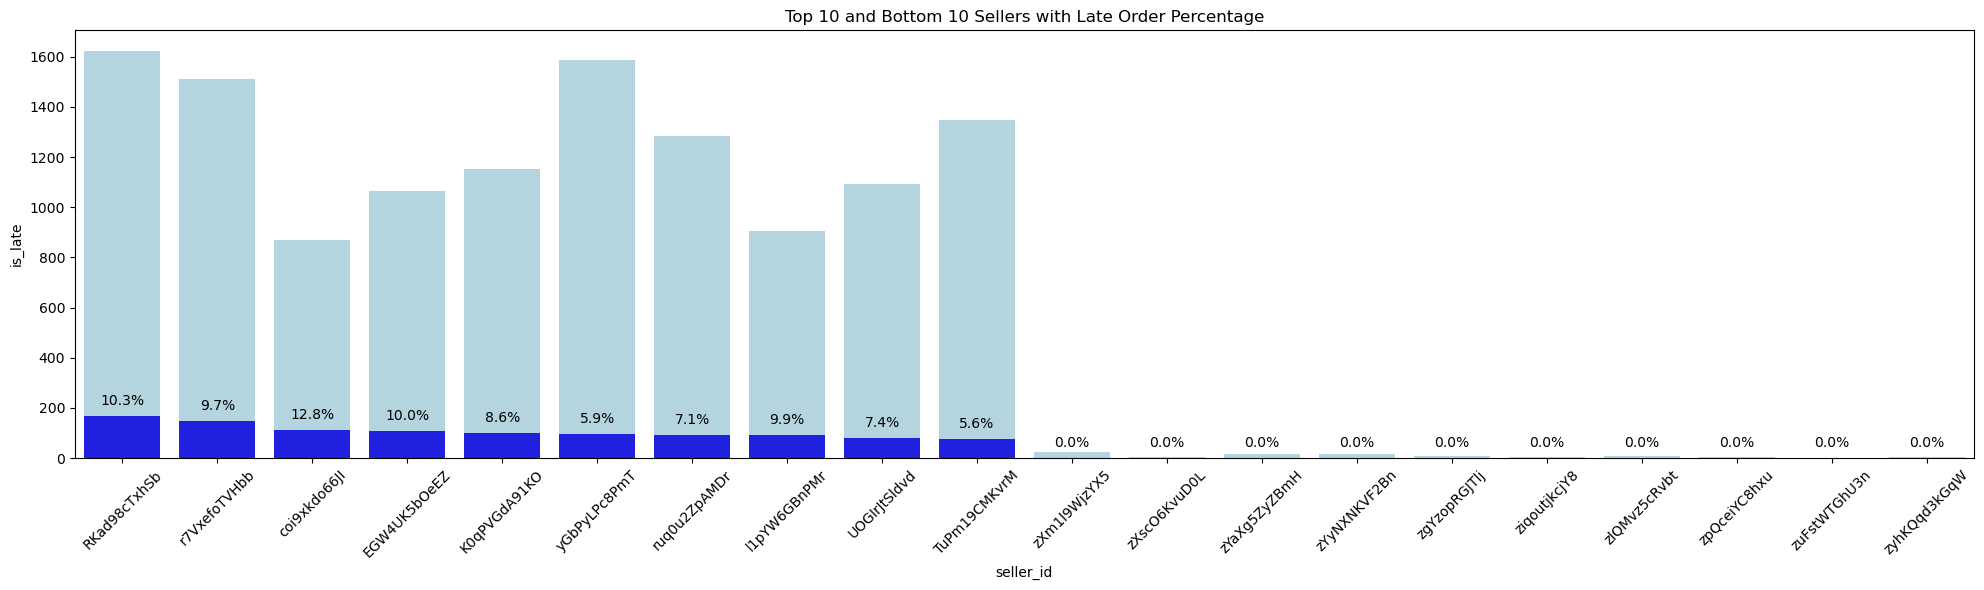

In [17]:
plt.figure(figsize=(20, 6))

sns.barplot(data=tmp, x='seller_id', y='count', color='lightblue')
sns.barplot(data=tmp, x='seller_id', y='is_late', color='blue')

for index, row in tmp.iterrows():
    plt.text(
        x=index, 
        y=row['is_late'] + 0.02 * max(tmp['count']),  # Positioning above the bar
        s=f"{row['percent']:.1f}%", 
        ha='center', va='bottom', color='black', fontsize=10
    )
plt.xticks(rotation=45)
plt.title("Top 10 and Bottom 10 Sellers with Late Order Percentage")

plt.tight_layout()
plt.show()

### 6. Shipping Charges

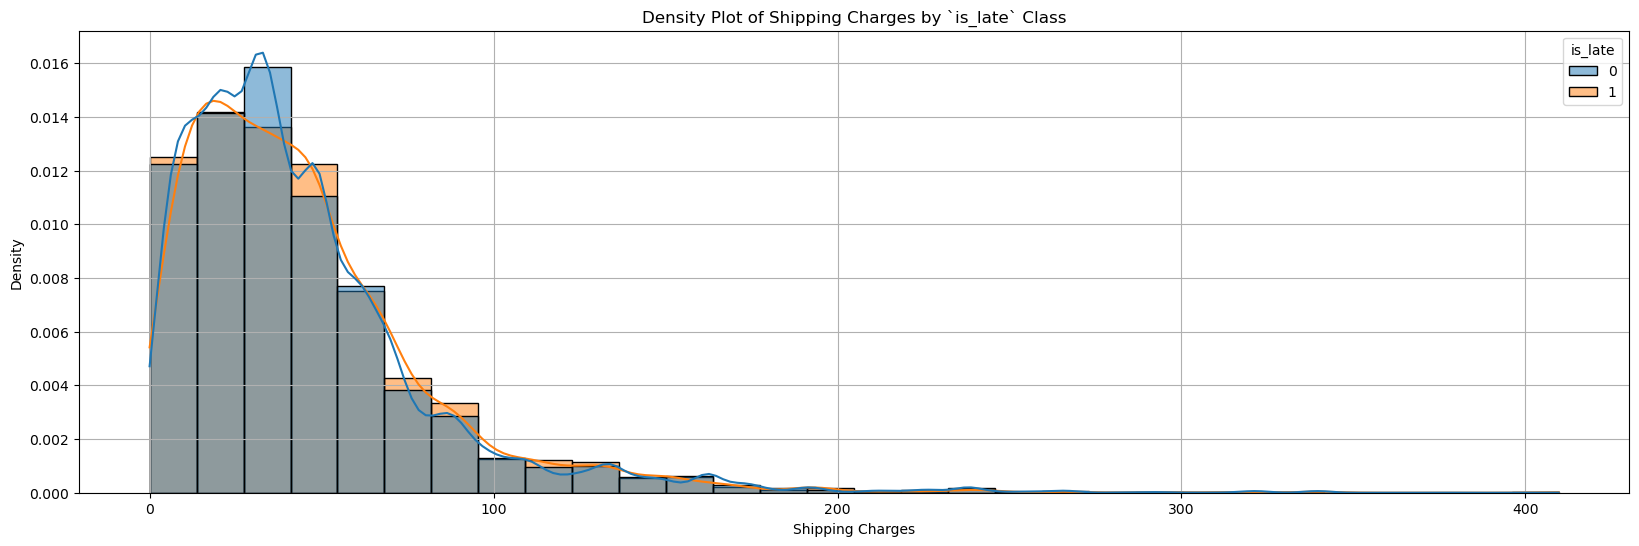

In [18]:
# Histogram with density plot
plt.figure(figsize=(20, 6))
sns.histplot(data=df, x='shipping_charges', hue='is_late', kde=True, stat='density', common_norm=False, bins=30)
plt.xlabel('Shipping Charges')
plt.ylabel('Density')
plt.title('Density Plot of Shipping Charges by `is_late` Class')
plt.grid(True)
plt.show()

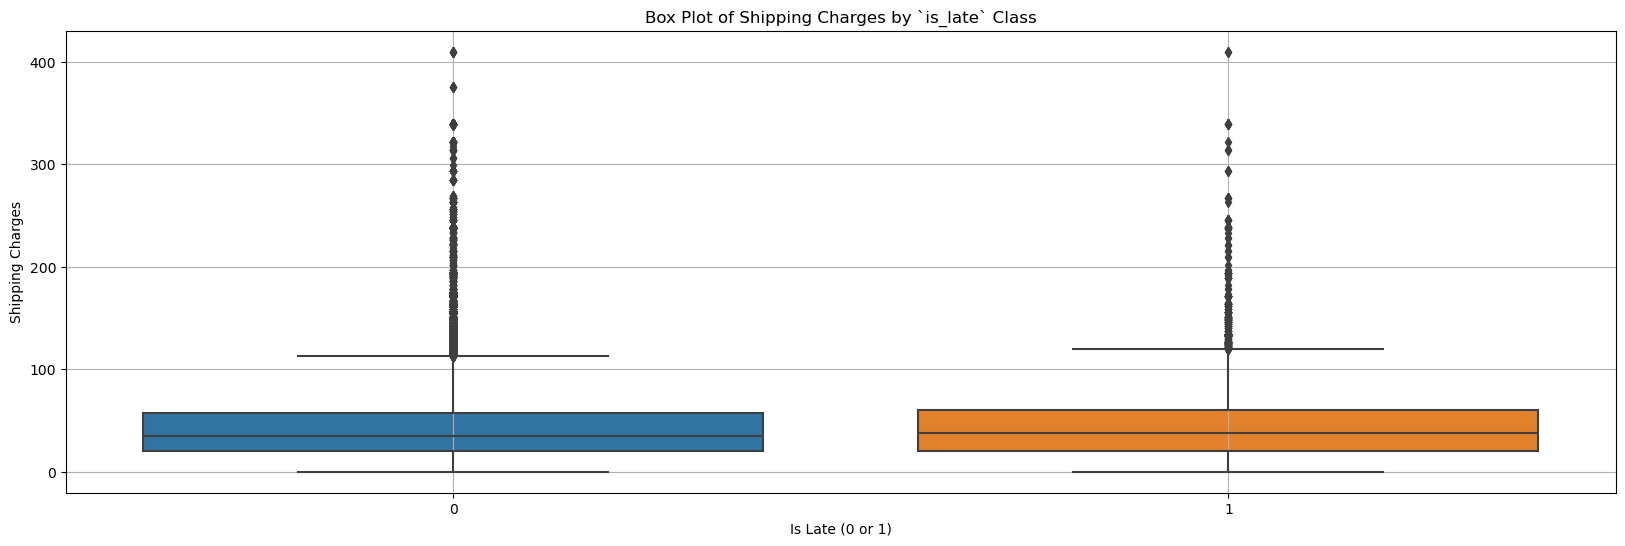

In [19]:
# Box plot to show distribution and outliers
plt.figure(figsize=(20, 6))
sns.boxplot(x='is_late', y='shipping_charges', data=df)
plt.xlabel('Is Late (0 or 1)')
plt.ylabel('Shipping Charges')
plt.title('Box Plot of Shipping Charges by `is_late` Class')
plt.grid(True)
plt.show()

* Observation - 
1. The distribution of Shipping prices are similar for late and normal orders
2. Nonethless, we can further explore this feature by binning the prices into three categories - low, medium and high

In [20]:
df['shipping_charges_cat'] = pd.qcut(df['shipping_charges'], q=3, labels=['low', 'medium', 'high'])
df.head(2)

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,product_id,seller_id,price,shipping_charges,...,product_weight_g,payment_sequential,payment_type,payment_installments,payment_value,is_late,product_volume,approve_estimated_diff,purchase_approve_diff,shipping_charges_cat
0,Axfy13Hk4PIk,hCT0x9JiGXBQ,2017-10-22 18:57:54,2017-10-22 19:14:13,2017-10-26 22:19:52,2017-11-09,90K0C1fIyQUf,ZWM05J9LcBSF,223.51,84.65,...,491.0,1,credit_card,1,259.14,0,3648.0,17.198461,0.011331,high
1,v6px92oS8cLG,PxA7fv9spyhx,2018-06-20 21:40:31,2018-06-20 22:20:20,2018-07-03 22:51:22,2018-07-24,qejhpMGGVcsl,IjlpYfhUbRQs,170.80,23.79,...,440.0,1,credit_card,8,382.39,0,4284.0,33.069213,0.027650,low


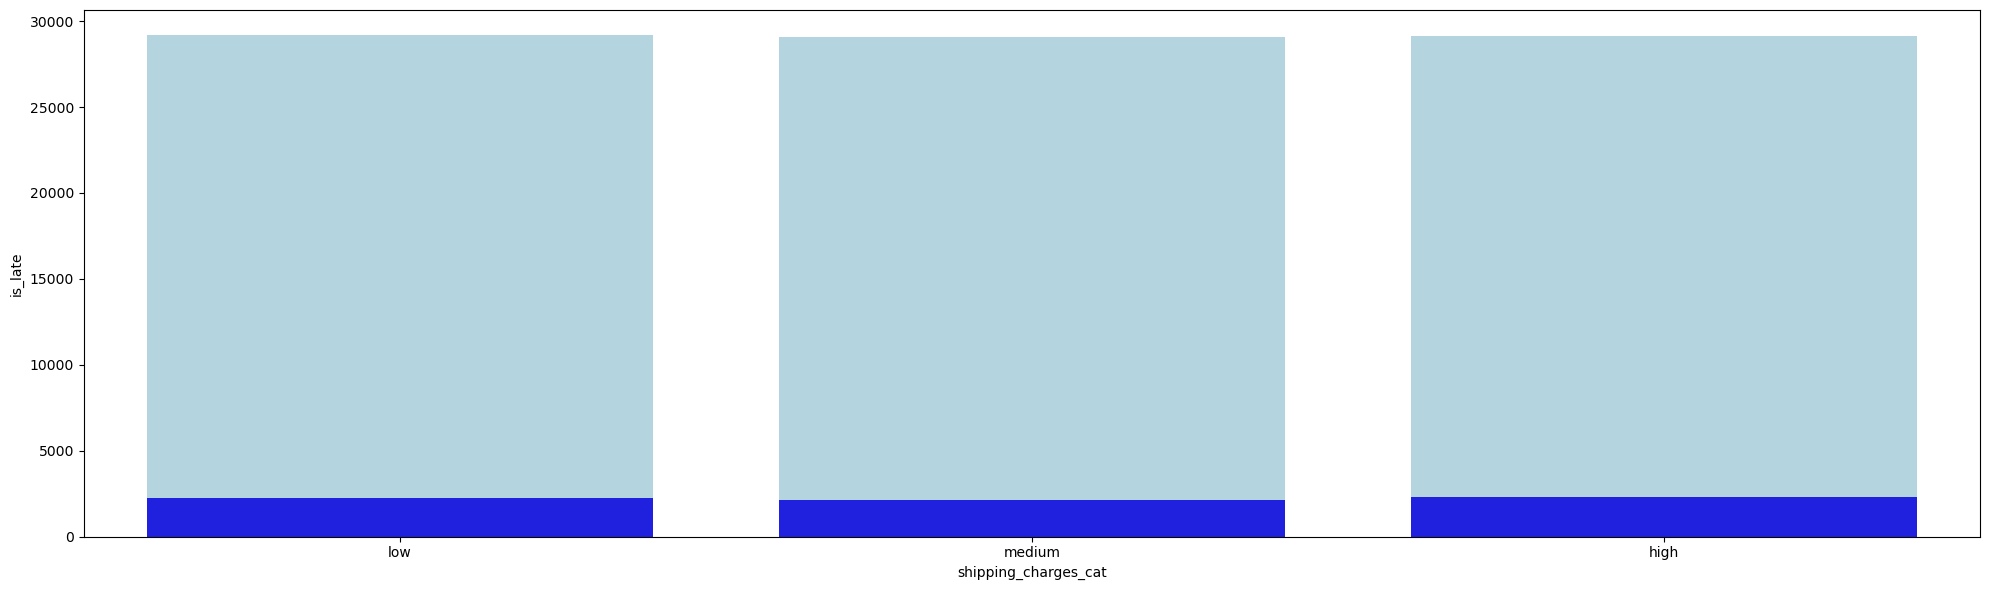

In [21]:
tmp = df[['shipping_charges_cat', 'is_late']].groupby('shipping_charges_cat').agg(
    is_late=('is_late', 'sum'),
    count=('shipping_charges_cat', 'size')
).sort_values(by='is_late', ascending=False).reset_index()
plt.figure(figsize=(20, 6))
sns.barplot(tmp, x='shipping_charges_cat', y='count', color='lightblue')
sns.barplot(tmp, x='shipping_charges_cat', y='is_late', color='blue')

plt.tight_layout()
plt.show()

* Observation -
1. It appears that shipping charges also do not influence whether an order is late

### 7. Customer Zip Code

There are 13841 zip codes and plot for top 10 and bottom 10 zipcodes


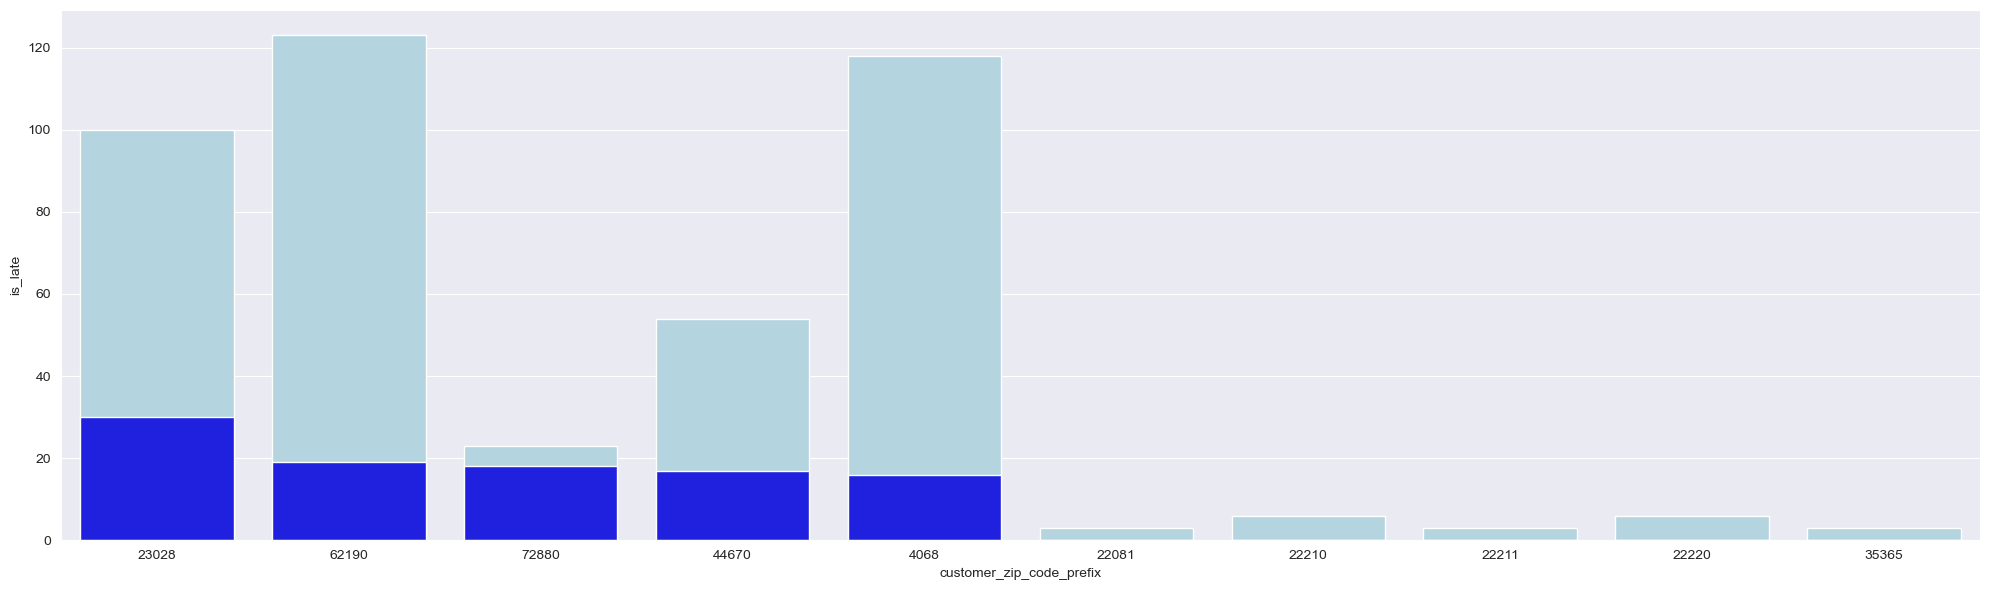

In [22]:
tmp = df[['customer_zip_code_prefix', 'is_late']].groupby('customer_zip_code_prefix').agg(
    is_late=('is_late', 'sum'),
    count=('customer_zip_code_prefix', 'size')
).reset_index().sort_values(by='is_late', ascending=False)

tmp = pd.concat([tmp.head(), tmp.tail()], ignore_index=True)
order = tmp['customer_zip_code_prefix']
sns.set_style('darkgrid')
plt.figure(figsize=(20, 6))
sns.barplot(data=tmp, x='customer_zip_code_prefix', y='count', color='lightblue', order=order)
sns.barplot(data=tmp, x='customer_zip_code_prefix', y='is_late', color='blue', order=order)

plt.tight_layout()
print(f"There are {len(df['customer_zip_code_prefix'].value_counts().keys())} zip codes and plot for top 10 and bottom 10 zipcodes")
plt.show()

* Observation
1. Some Zip codes has high chances of late orders and some have none.

### 8. Customer City

There are 3713 Cities and plot for top 10 and bottom 10 cities


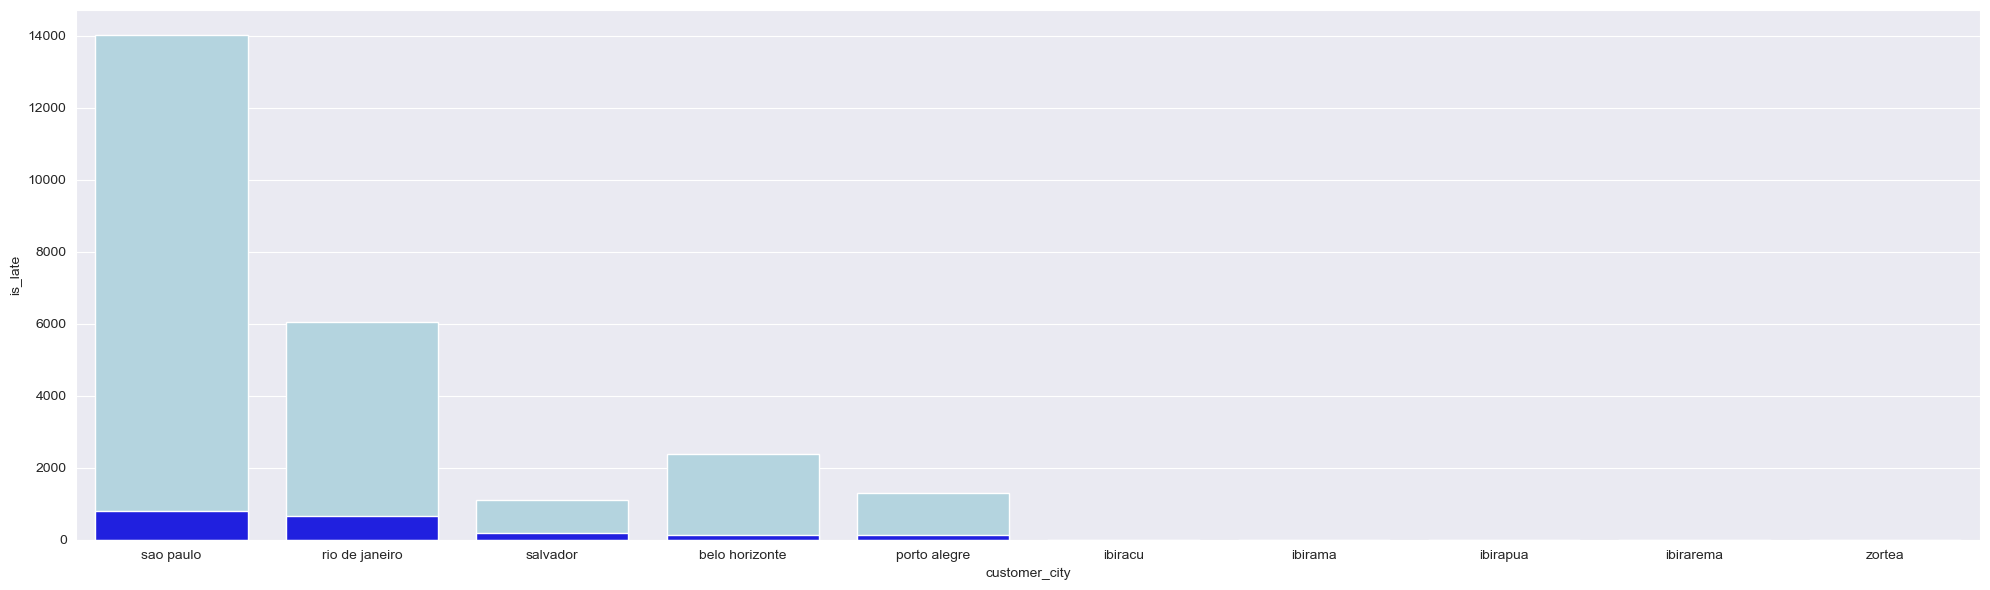

In [23]:
tmp = df[['customer_city', 'is_late']].groupby('customer_city').agg(
    is_late=('is_late', 'sum'),
    count=('customer_city', 'size')
).reset_index().sort_values(by='is_late', ascending=False)

tmp = pd.concat([tmp.head(), tmp.tail()], ignore_index=True)
order = tmp['customer_city']
sns.set_style('darkgrid')
plt.figure(figsize=(20, 6))
sns.barplot(data=tmp, x='customer_city', y='count', color='lightblue', order=order)
sns.barplot(data=tmp, x='customer_city', y='is_late', color='blue', order=order)

plt.tight_layout()
print(f"There are {len(df['customer_city'].value_counts().keys())} Cities and plot for top 10 and bottom 10 cities")
plt.show()

* Observations - 
1. Customer City have less of a effect on whether order will be late or not

### 9. Customer State

There are 27 States and plot for top 10 and bottom 10 states


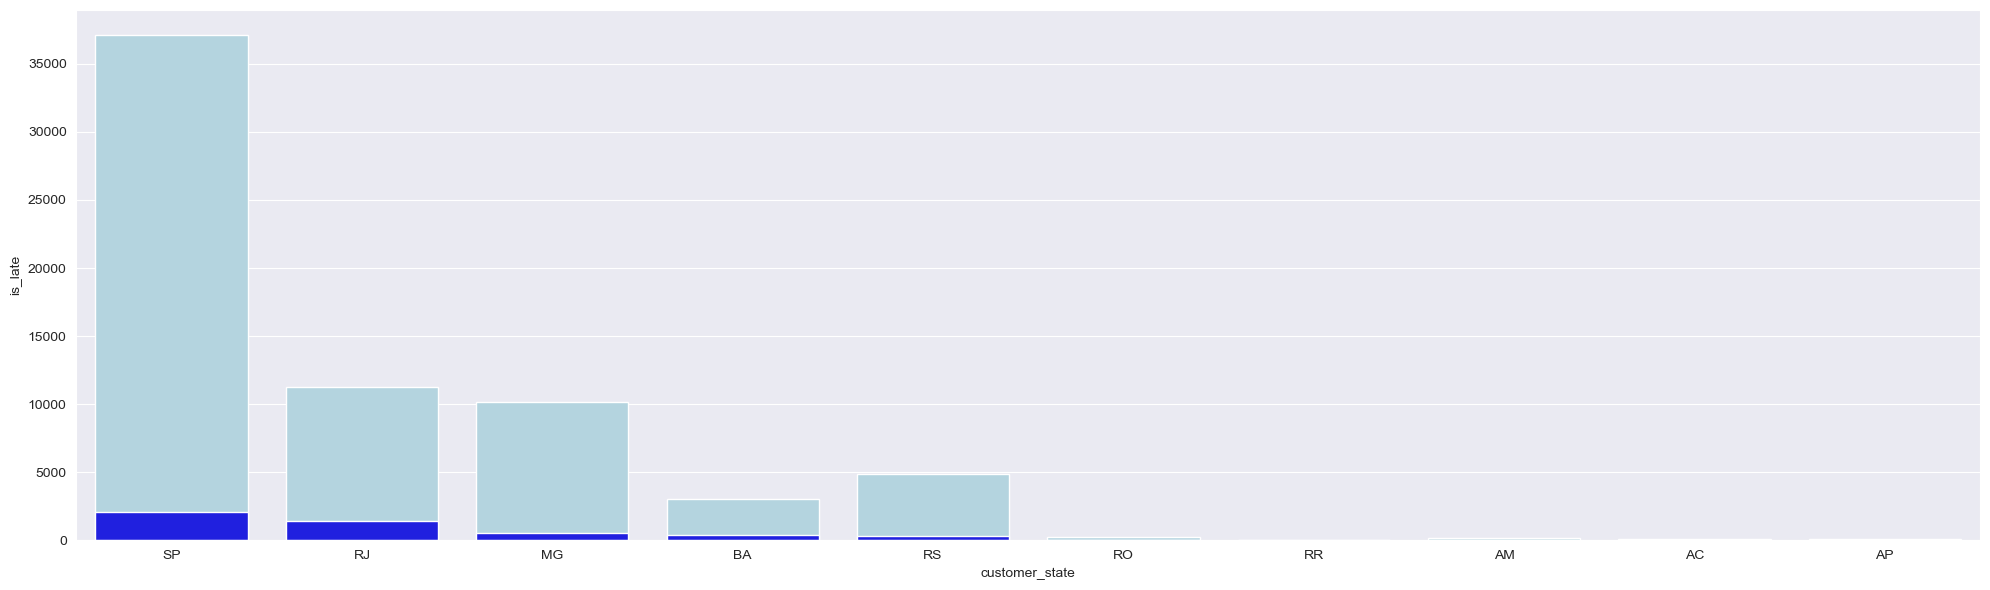

In [24]:
tmp = df[['customer_state', 'is_late']].groupby('customer_state').agg(
    is_late=('is_late', 'sum'),
    count=('customer_state', 'size')
).reset_index().sort_values(by='is_late', ascending=False)

tmp = pd.concat([tmp.head(), tmp.tail()], ignore_index=True)
order = tmp['customer_state']
sns.set_style('darkgrid')
plt.figure(figsize=(20, 6))
sns.barplot(data=tmp, x='customer_state', y='count', color='lightblue', order=order)
sns.barplot(data=tmp, x='customer_state', y='is_late', color='blue', order=order)

plt.tight_layout()
print(f"There are {len(df['customer_state'].value_counts().keys())} States and plot for top 10 and bottom 10 states")
plt.show()

* Observations - 
1. Customer state have less of a effect on whether order will be late or not

### 10. Product Id

There are 26849 Product Ids and plot for top 10 and bottom 10 Product Ids


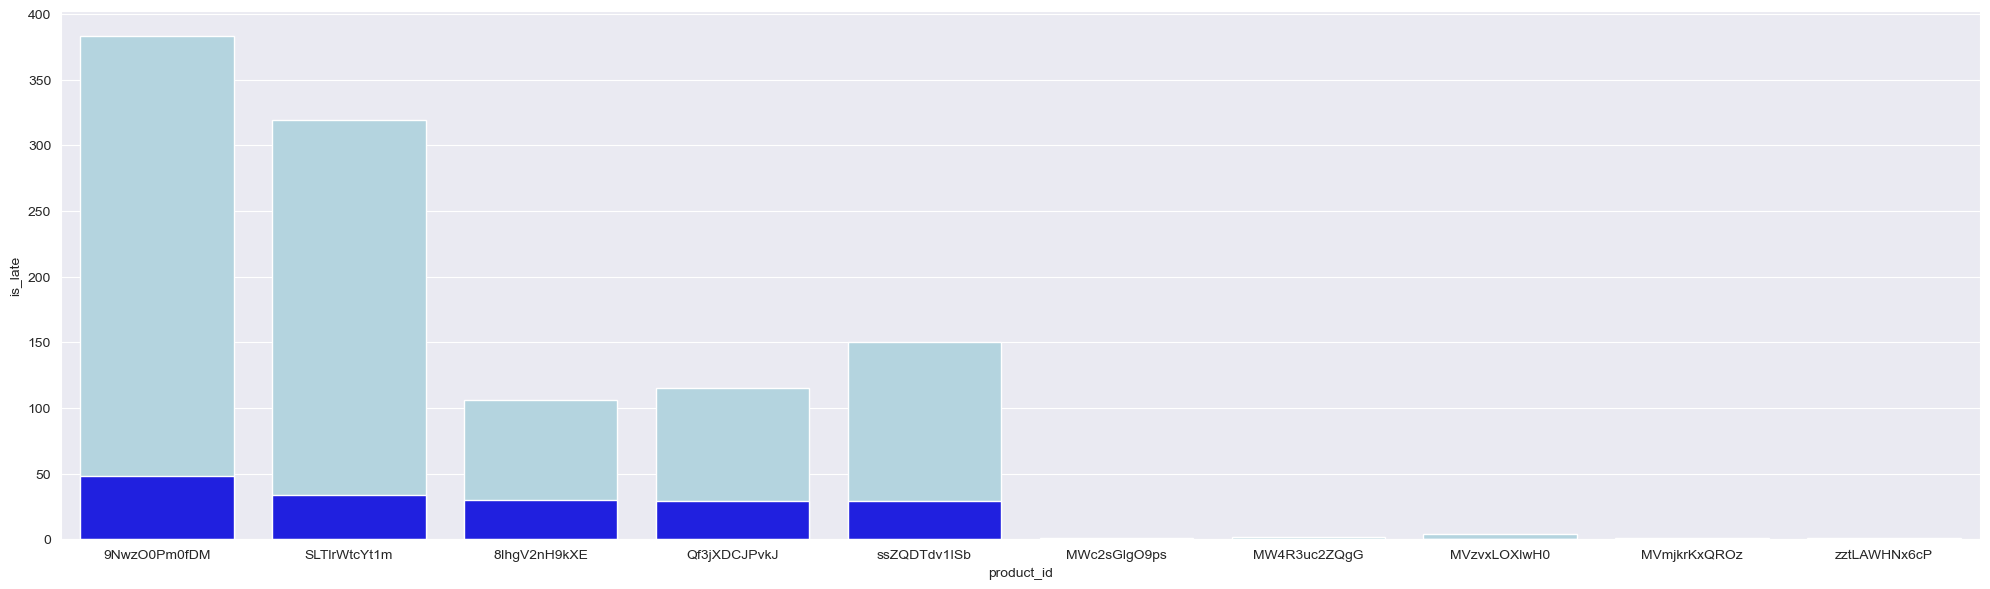

In [25]:
tmp = df[['product_id', 'is_late']].groupby('product_id').agg(
    is_late=('is_late', 'sum'),
    count=('product_id', 'size')
).reset_index().sort_values(by='is_late', ascending=False)

tmp = pd.concat([tmp.head(), tmp.tail()], ignore_index=True)
order = tmp['product_id']
sns.set_style('darkgrid')
plt.figure(figsize=(20, 6))
sns.barplot(data=tmp, x='product_id', y='count', color='lightblue', order=order)
sns.barplot(data=tmp, x='product_id', y='is_late', color='blue', order=order)

plt.tight_layout()
print(f"There are {len(df['product_id'].value_counts().keys())} Product Ids and plot for top 10 and bottom 10 Product Ids")
plt.show()

* Observations
1. Some product ids have more chance of getting late as compared to others

### 11. Product Price

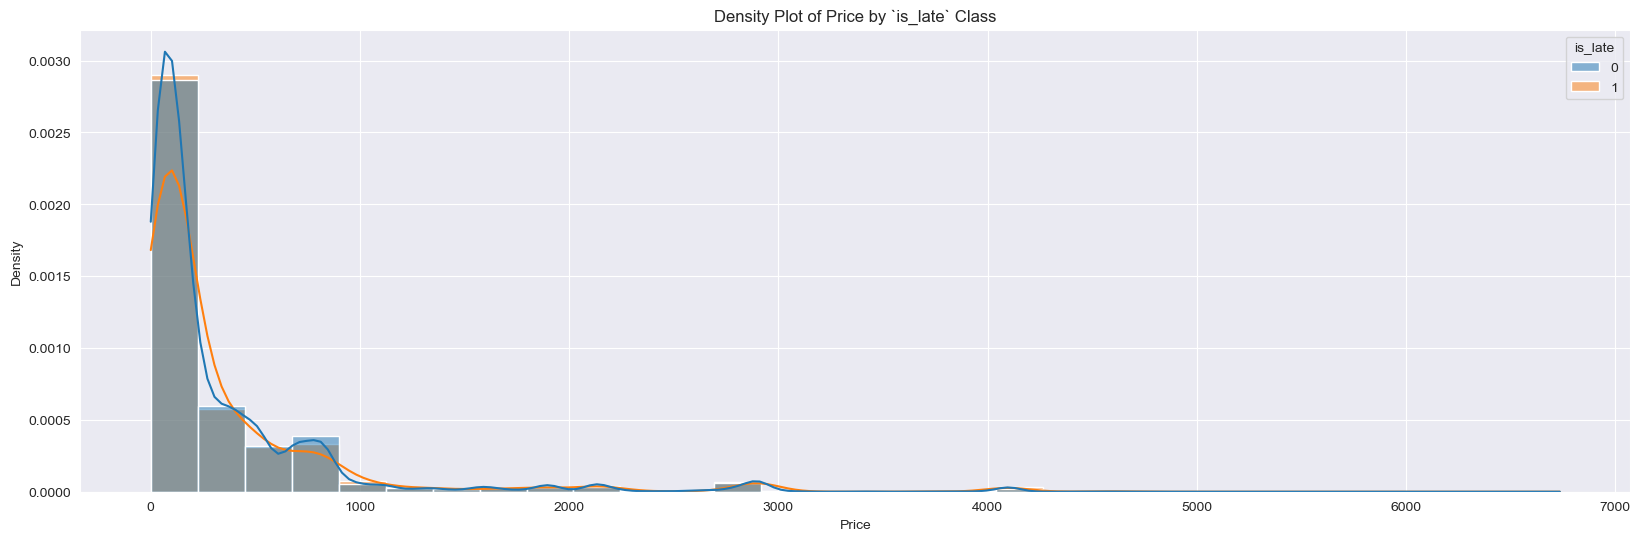

In [26]:
# Histogram with density plot
plt.figure(figsize=(20, 6))
sns.histplot(data=df, x='price', hue='is_late', kde=True, stat='density', common_norm=False, bins=30)
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Density Plot of Price by `is_late` Class')
plt.grid(True)
plt.show()

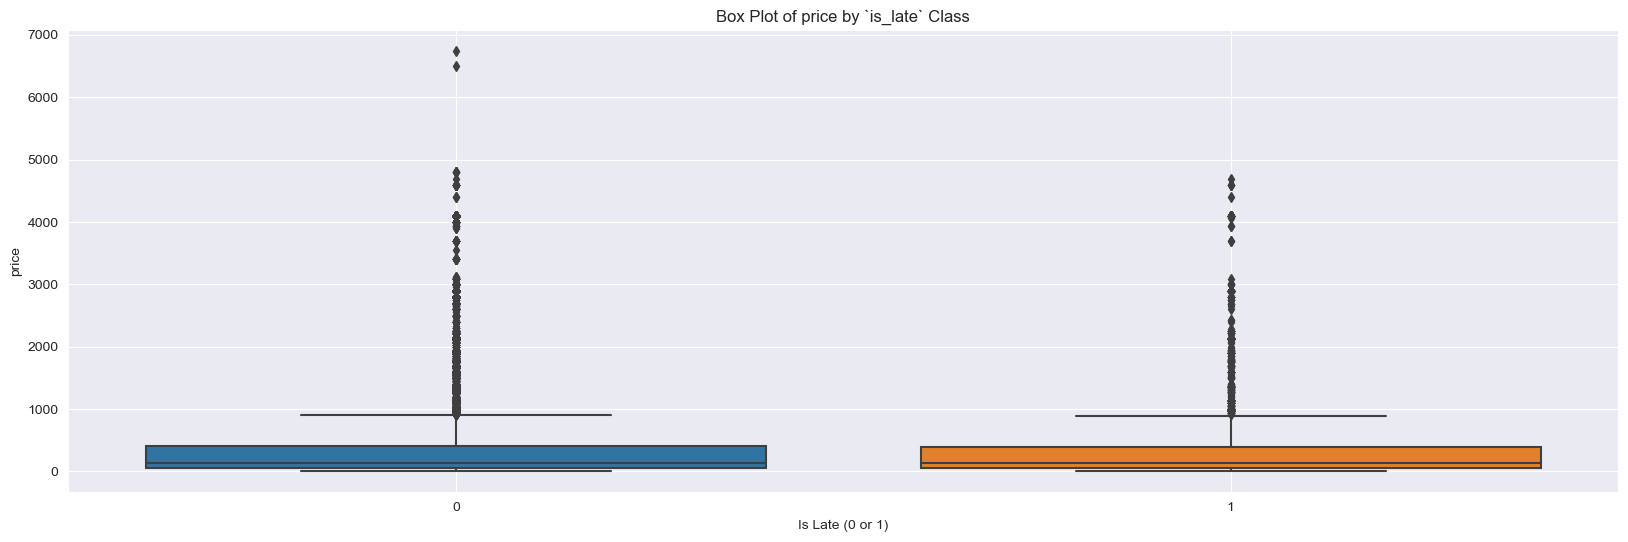

In [27]:
# Box plot to show distribution and outliers
plt.figure(figsize=(20, 6))
sns.boxplot(x='is_late', y='price', data=df)
plt.xlabel('Is Late (0 or 1)')
plt.ylabel('price')
plt.title('Box Plot of price by `is_late` Class')
plt.grid(True)
plt.show()

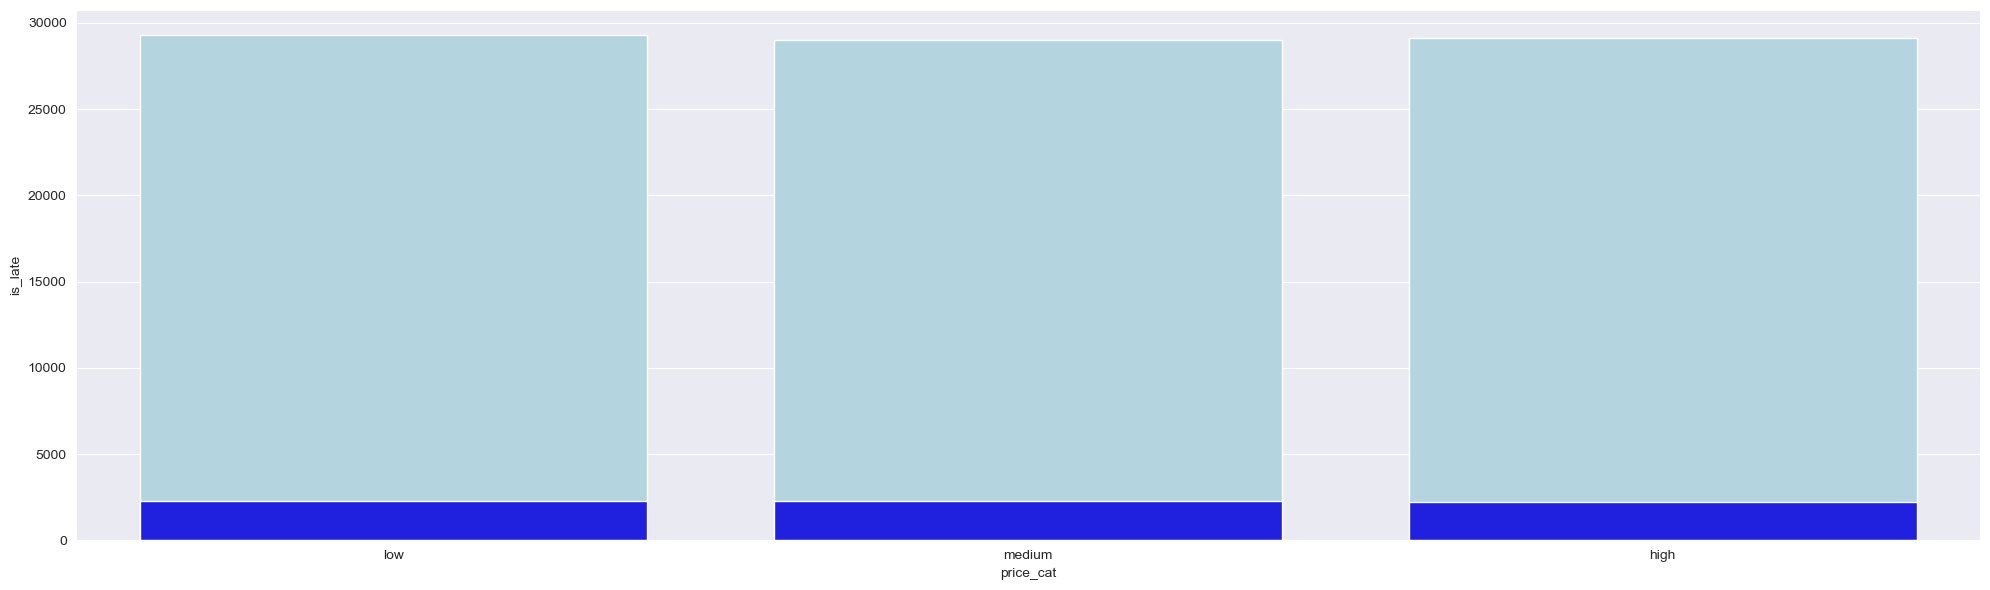

In [28]:
df['price_cat'] = pd.qcut(df['price'], q=3, labels=['low', 'medium', 'high'])

tmp = df[['price_cat', 'is_late']].groupby('price_cat').agg(
    is_late=('is_late', 'sum'),
    count=('price_cat', 'size')
).sort_values(by='is_late', ascending=False).reset_index()
plt.figure(figsize=(20, 6))
sns.barplot(tmp, x='price_cat', y='count', color='lightblue')
sns.barplot(tmp, x='price_cat', y='is_late', color='blue')

plt.tight_layout()
plt.show()

* Observations - 
1. It appears that the price of the order also don't have any effect on whether order will be late or not

### 12. Product Category

There are 70 Product Categories and plot for top 10 and bottom 10 Product Categories


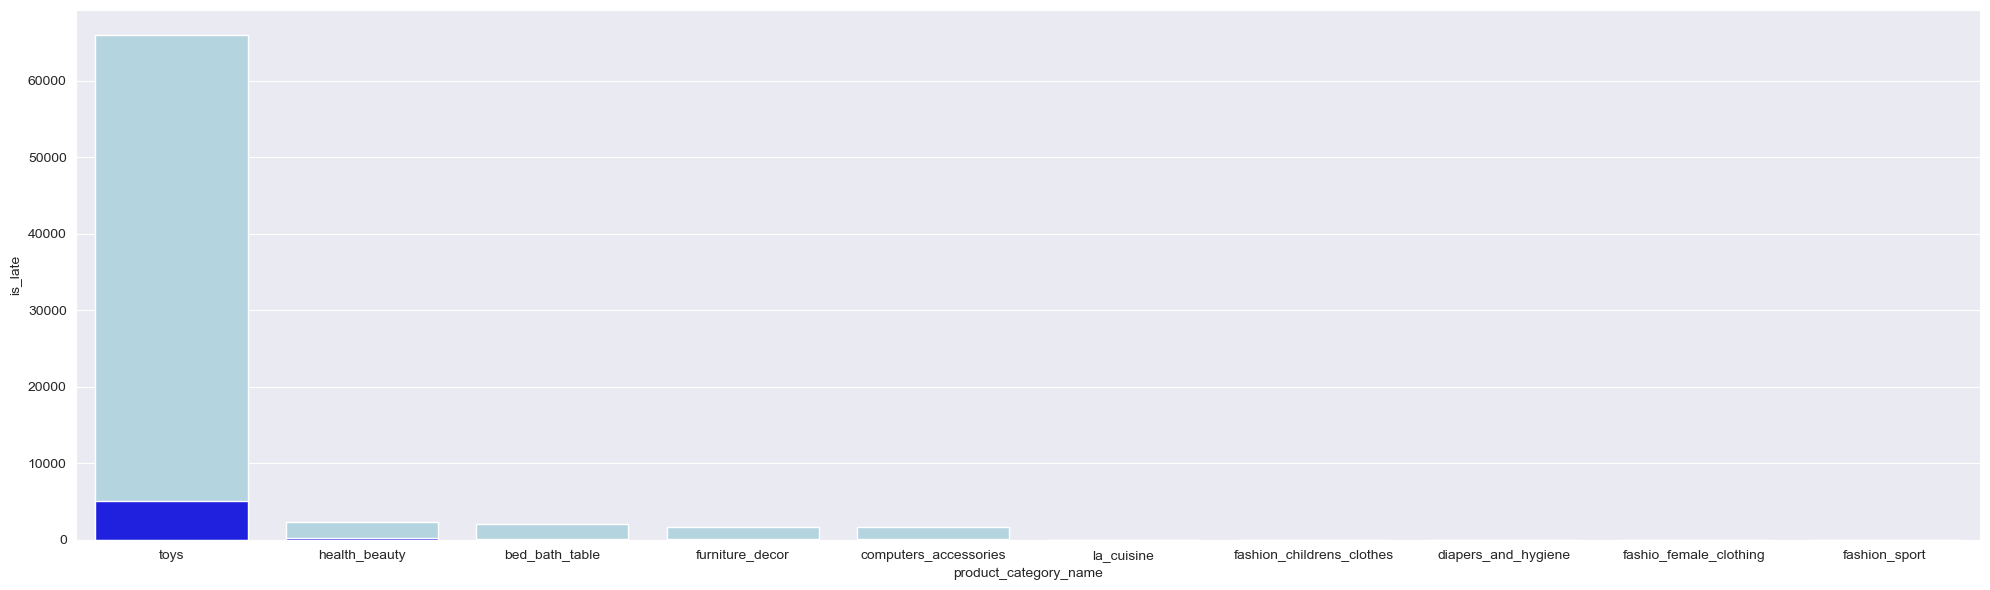

In [29]:
# df['product_category_name'].value_counts()
tmp = df[['product_category_name', 'is_late']].groupby('product_category_name').agg(
    is_late=('is_late', 'sum'),
    count=('product_category_name', 'size')
).reset_index().sort_values(by='is_late', ascending=False)

tmp = pd.concat([tmp.head(), tmp.tail()], ignore_index=True)
order = tmp['product_category_name']
sns.set_style('darkgrid')
plt.figure(figsize=(20, 6))
sns.barplot(data=tmp, x='product_category_name', y='count', color='lightblue', order=order)
sns.barplot(data=tmp, x='product_category_name', y='is_late', color='blue', order=order)

plt.tight_layout()
print(f"There are {len(df['product_category_name'].value_counts().keys())} Product Categories and plot for top 10 and bottom 10 Product Categories")
plt.show()

* Observations 
1. The product under toy category have largest number of late orders with 5115/65922 late orders and of 6737 total late orders
2. This suggest that orders for product under toy category are more likely to be late

### 12. Product Weight

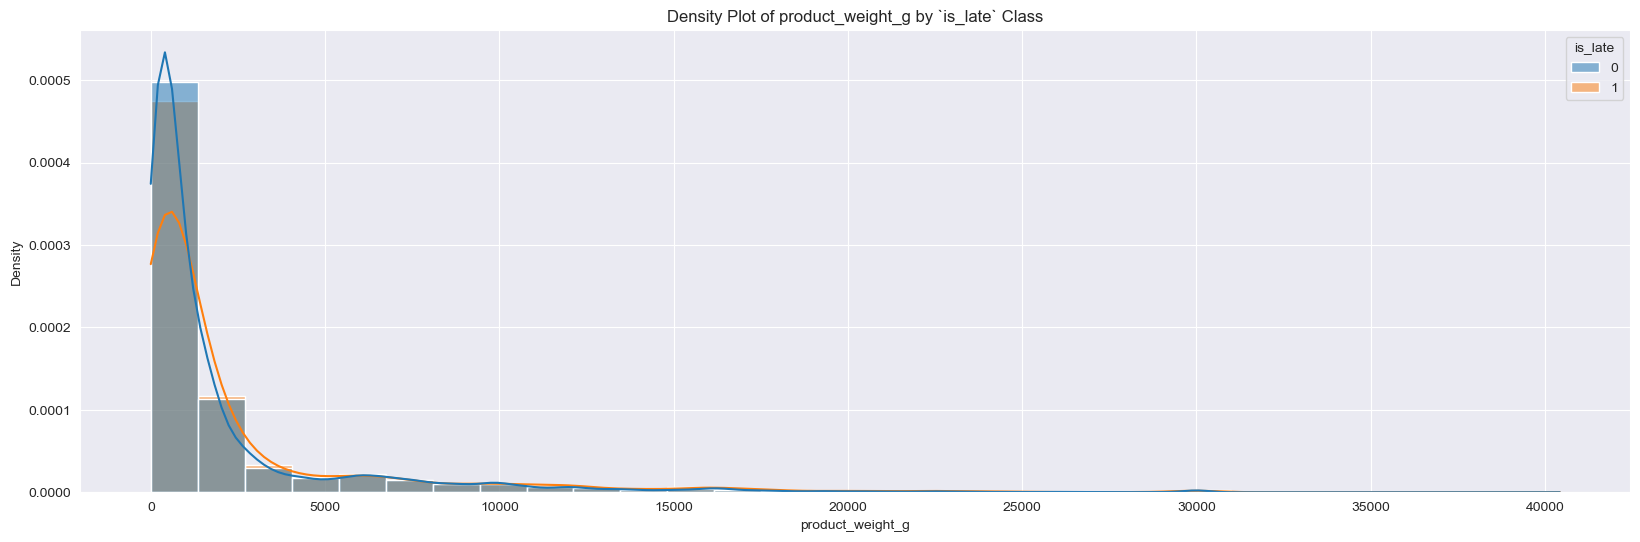

In [30]:
# Histogram with density plot
plt.figure(figsize=(20, 6))
sns.histplot(data=df, x='product_weight_g', hue='is_late', kde=True, stat='density', common_norm=False, bins=30)
plt.xlabel('product_weight_g')
plt.ylabel('Density')
plt.title('Density Plot of product_weight_g by `is_late` Class')
plt.grid(True)
plt.show()

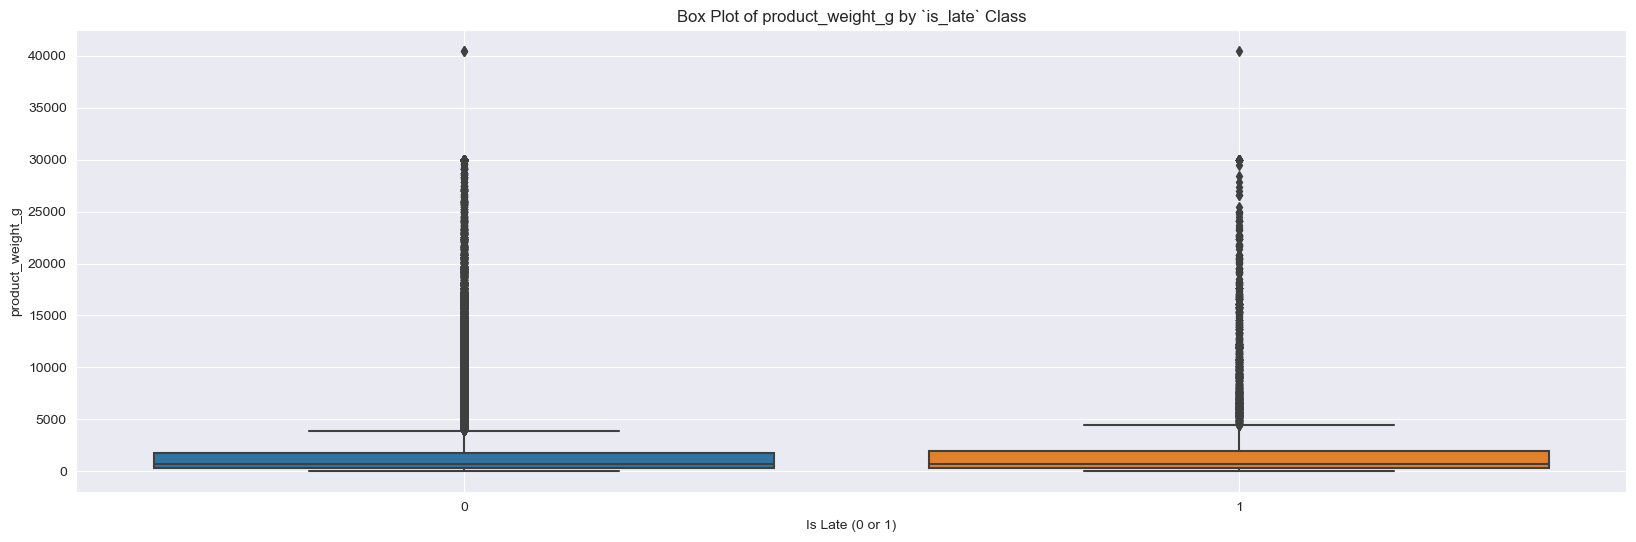

In [31]:
# Box plot to show distribution and outliers
plt.figure(figsize=(20, 6))
sns.boxplot(x='is_late', y='product_weight_g', data=df)
plt.xlabel('Is Late (0 or 1)')
plt.ylabel('product_weight_g')
plt.title('Box Plot of product_weight_g by `is_late` Class')
plt.grid(True)
plt.show()

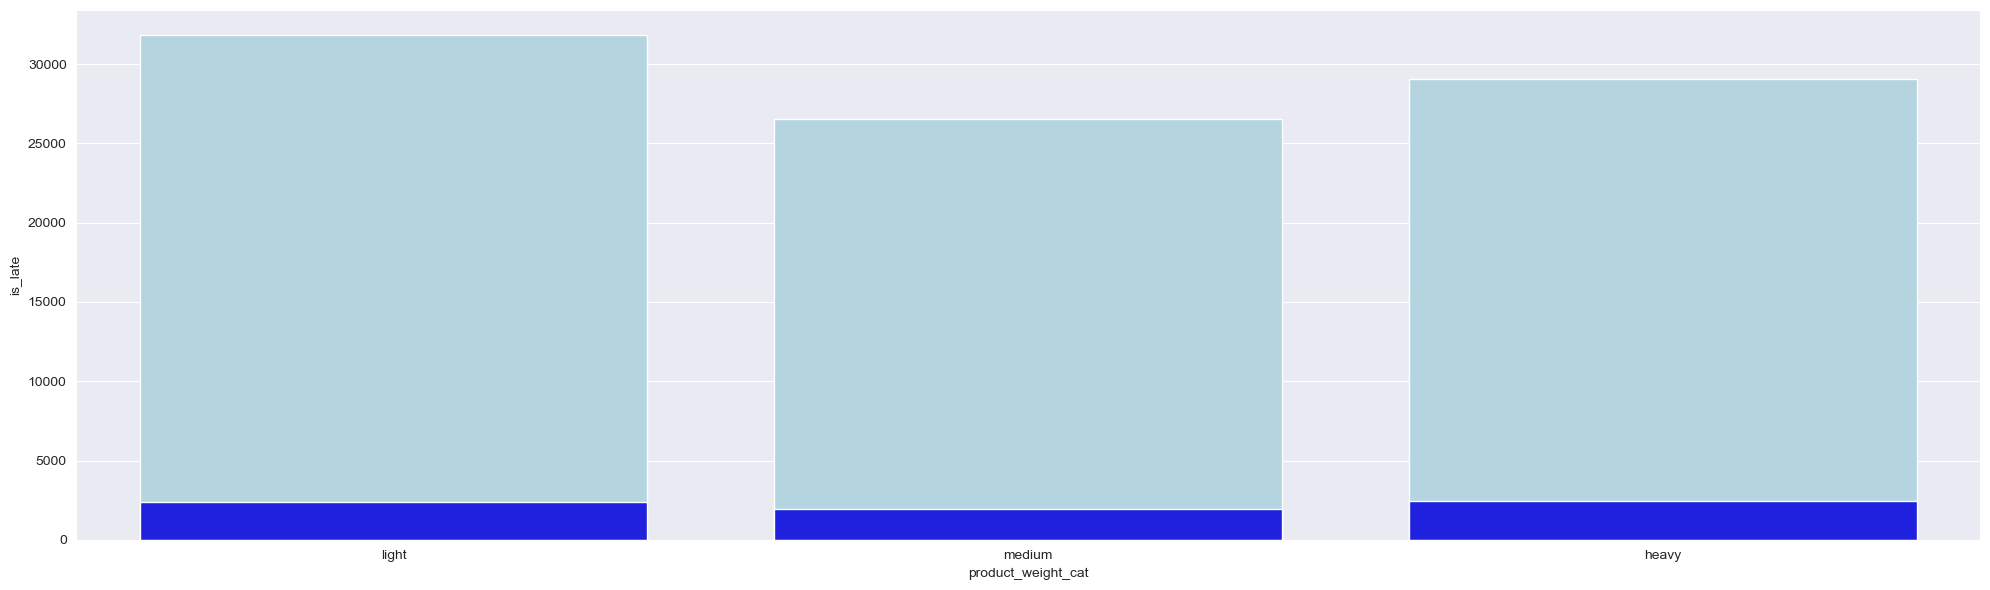

In [32]:
df['product_weight_cat'] = pd.qcut(df['product_weight_g'], q=3, labels=['light', 'medium', 'heavy'])

tmp = df[['product_weight_cat', 'is_late']].groupby('product_weight_cat').agg(
    is_late=('is_late', 'sum'),
    count=('product_weight_cat', 'size')
).sort_values(by='is_late', ascending=False).reset_index()
plt.figure(figsize=(20, 6))
sns.barplot(tmp, x='product_weight_cat', y='count', color='lightblue')
sns.barplot(tmp, x='product_weight_cat', y='is_late', color='blue')

plt.tight_layout()
plt.show()

* Observations
1. Weight also don't have anything to do with order being late or not

### 13. Product Volume

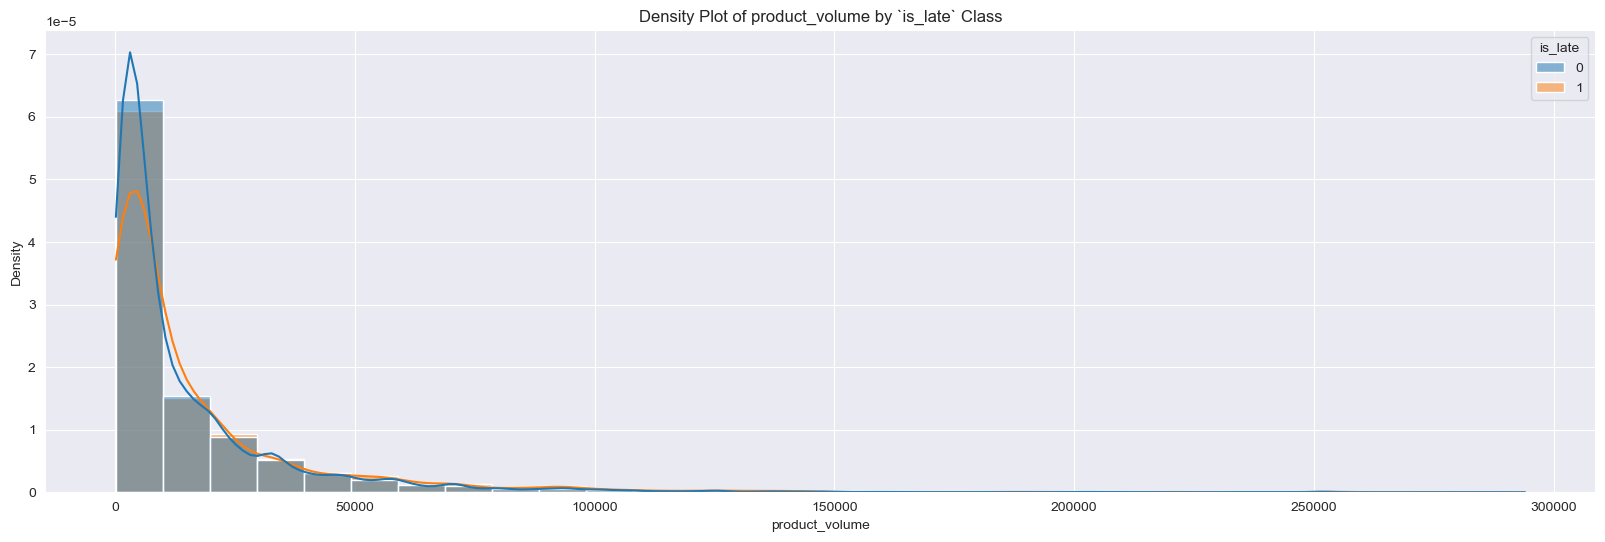

In [33]:
# Histogram with density plot
plt.figure(figsize=(20, 6))
sns.histplot(data=df, x='product_volume', hue='is_late', kde=True, stat='density', common_norm=False, bins=30)
plt.xlabel('product_volume')
plt.ylabel('Density')
plt.title('Density Plot of product_volume by `is_late` Class')
plt.grid(True)
plt.show()

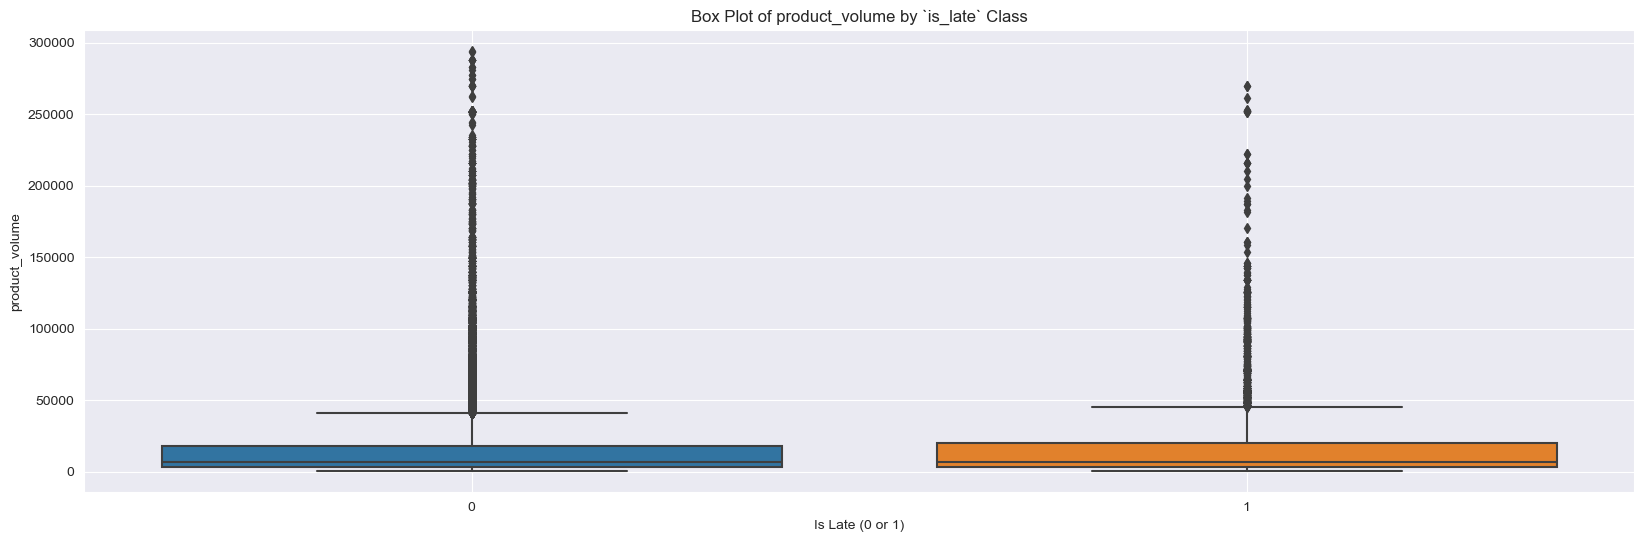

In [34]:
# Box plot to show distribution and outliers
plt.figure(figsize=(20, 6))
sns.boxplot(x='is_late', y='product_volume', data=df)
plt.xlabel('Is Late (0 or 1)')
plt.ylabel('product_volume')
plt.title('Box Plot of product_volume by `is_late` Class')
plt.grid(True)
plt.show()

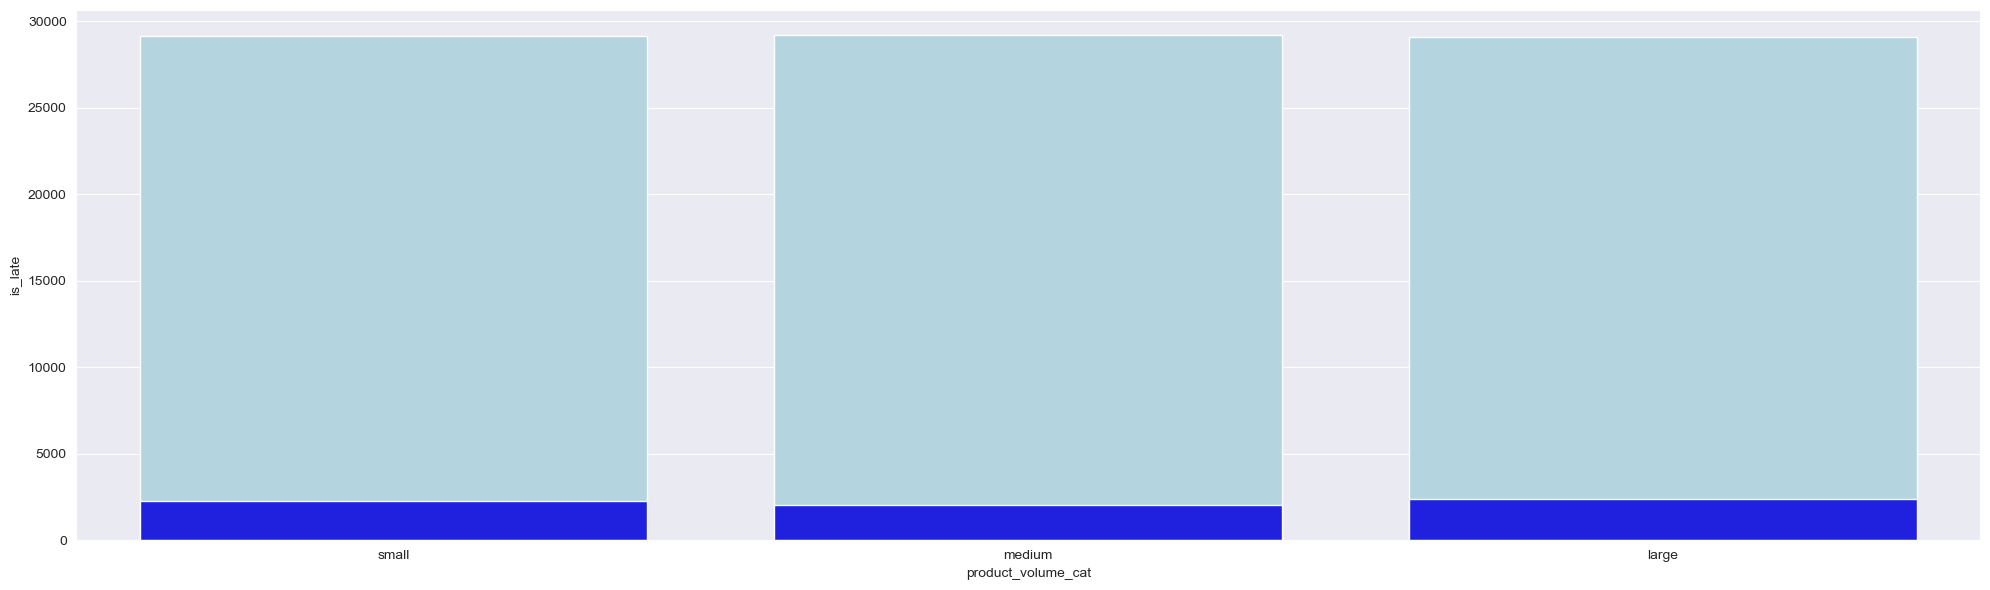

In [35]:
df['product_volume_cat'] = pd.qcut(df['product_volume'], q=3, labels=['small', 'medium', 'large'])

tmp = df[['product_volume_cat', 'is_late']].groupby('product_volume_cat').agg(
    is_late=('is_late', 'sum'),
    count=('product_volume_cat', 'size')
).sort_values(by='is_late', ascending=False).reset_index()
plt.figure(figsize=(20, 6))
sns.barplot(tmp, x='product_volume_cat', y='count', color='lightblue')
sns.barplot(tmp, x='product_volume_cat', y='is_late', color='blue')

plt.tight_layout()
plt.show()

* Observation - 
1. Product volume also don't have any effect on order status

### 14. Payment Sequencial

In [36]:
df['payment_sequential'].value_counts().head()

payment_sequential
1    83588
2     2534
3      486
4      232
5      150
Name: count, dtype: int64

There are 26 payment_sequential and plot for top 10 and bottom 10 payment_sequential


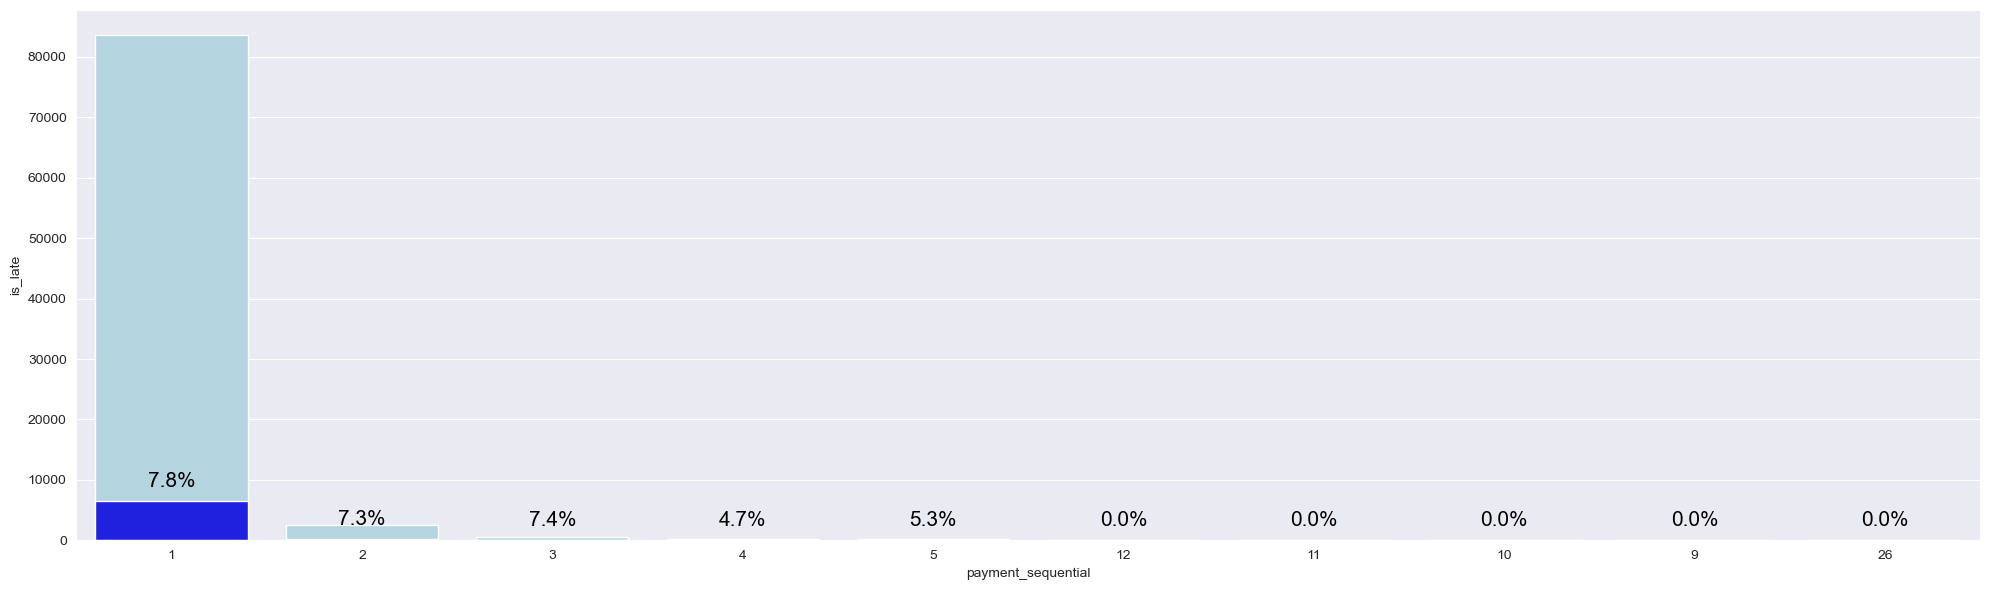

In [37]:
# tmp = df[['payment_sequential', 'is_late']].groupby('payment_sequential')
# df['product_category_name'].value_counts()
tmp = df[['payment_sequential', 'is_late']].groupby('payment_sequential').agg(
    is_late=('is_late', 'sum'),
    count=('payment_sequential', 'size')
).reset_index().sort_values(by='is_late', ascending=False)

tmp = pd.concat([tmp.head(), tmp.tail()], ignore_index=True)
order = tmp['payment_sequential']
tmp['percent'] = (tmp['is_late']/tmp['count'])*100
sns.set_style('darkgrid')
plt.figure(figsize=(20, 6))
sns.barplot(data=tmp, x='payment_sequential', y='count', color='lightblue', order=order)
sns.barplot(data=tmp, x='payment_sequential', y='is_late', color='blue', order=order)

for idx, row in tmp.iterrows():
    plt.text(x=idx, y=row['is_late'] + 0.02 * max(tmp['count']),
    s=f"{row['percent']:.1f}%",
    ha='center', va='bottom', color='black', fontsize=15
)

plt.tight_layout()
print(f"There are {len(df['payment_sequential'].value_counts().keys())} payment_sequential and plot for top 10 and bottom 10 payment_sequential")
plt.show()

* Observations - 
1. Since most of the orders are with one payment sequencial- number of late orders are highest for this category

### 15. Payment Type

There are 4 payment_type and plot for top 10 and bottom 10 payment_type


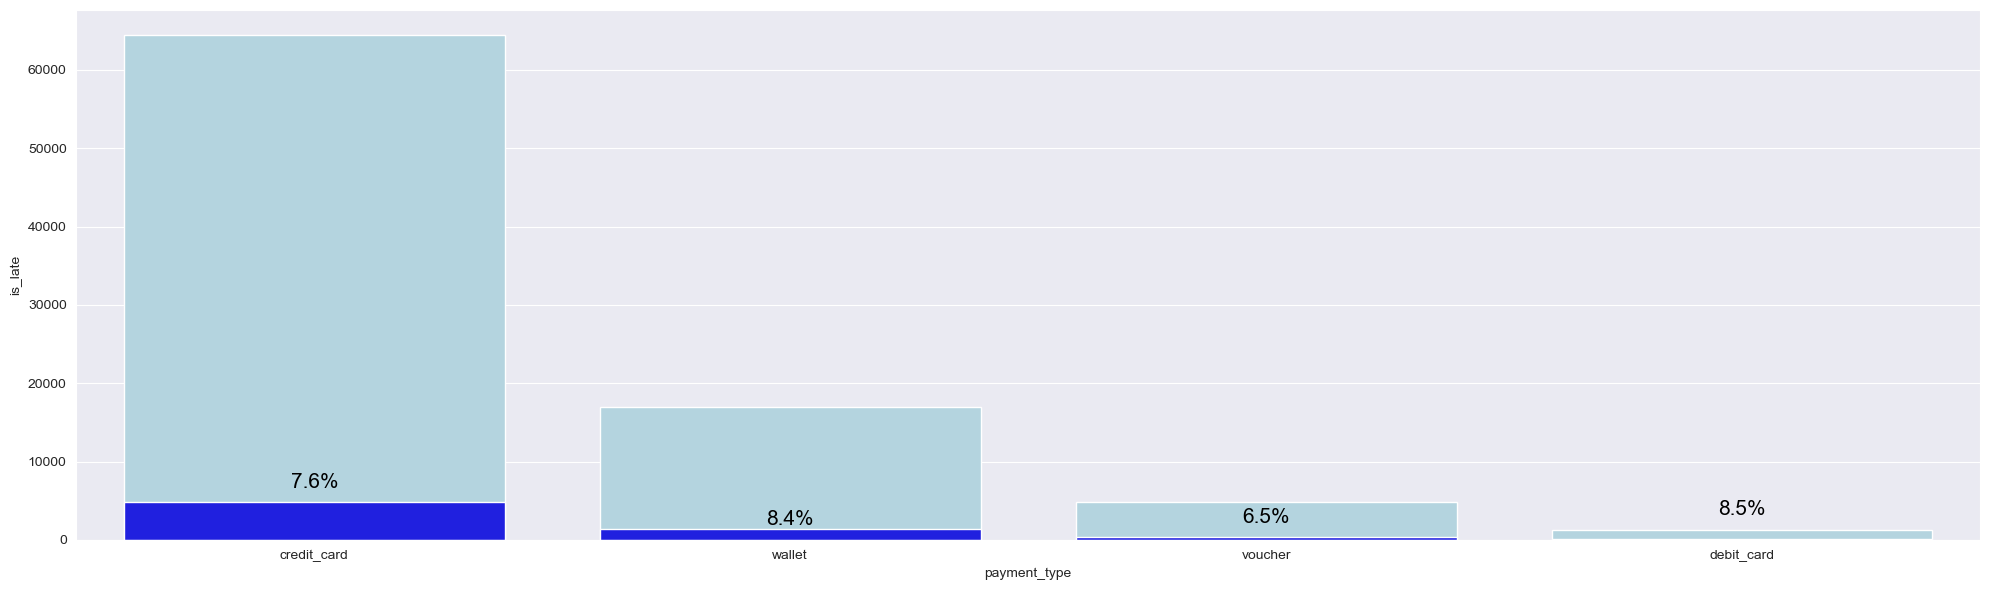

In [38]:
# df['payment_type'].value_counts()

tmp = df[['payment_type', 'is_late']].groupby('payment_type').agg(
    is_late=('is_late', 'sum'),
    count=('payment_type', 'size')
).reset_index().sort_values(by='is_late', ascending=False)

# tmp = pd.concat([tmp.head(), tmp.tail()], ignore_index=True)
order = tmp['payment_type']
tmp['percent'] = (tmp['is_late']/tmp['count'])*100
sns.set_style('darkgrid')
plt.figure(figsize=(20, 6))
sns.barplot(data=tmp, x='payment_type', y='count', color='lightblue', order=order)
sns.barplot(data=tmp, x='payment_type', y='is_late', color='blue', order=order)

for idx, row in tmp.iterrows():
    plt.text(x=idx, y=row['is_late'] + 0.02 * max(tmp['count']),
    s=f"{row['percent']:.1f}%",
    ha='center', va='bottom', color='black', fontsize=15
)

plt.tight_layout()
print(f"There are {len(df['payment_type'].value_counts().keys())} payment_type and plot for top 10 and bottom 10 payment_type")
plt.show()

* Observations
1. Majority of the trasactions are done through credit cards and as expected we have highest number of late orders for this payment method
2. Other payment methods also have similar proportions of late orders

### 16. Payment Installments

In [39]:
df['payment_installments'].value_counts().head()

payment_installments
1     43375
2     10121
3      8702
4      5917
10     5210
Name: count, dtype: int64

There are 24 payment_installments and plot for top 10 and bottom 10 payment_installments


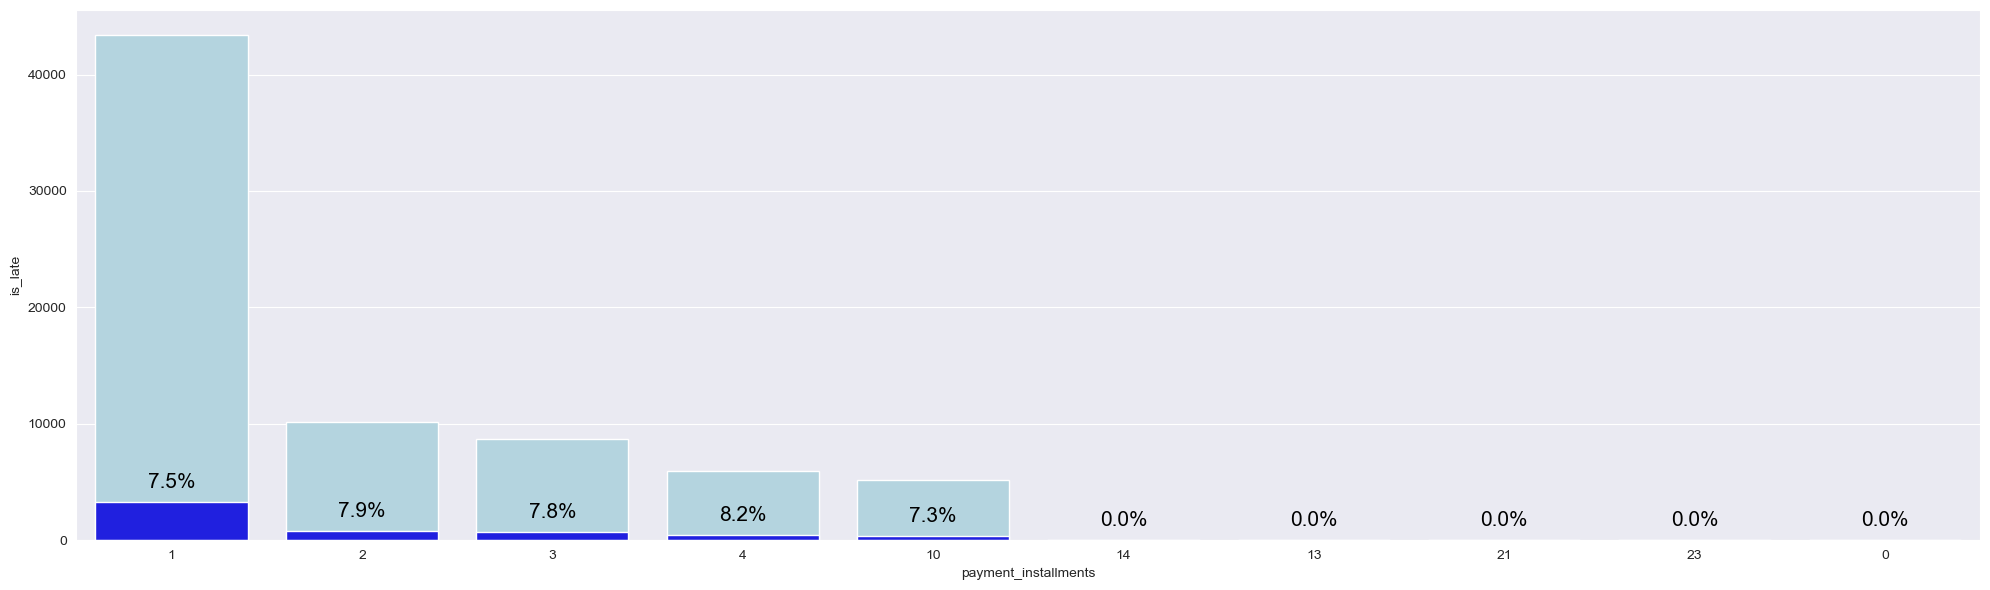

In [40]:
tmp = df[['payment_installments', 'is_late']].groupby('payment_installments').agg(
    is_late=('is_late', 'sum'),
    count=('payment_installments', 'size')
).reset_index().sort_values(by='is_late', ascending=False)

tmp = pd.concat([tmp.head(), tmp.tail()], ignore_index=True)
order = tmp['payment_installments']
tmp['percent'] = (tmp['is_late']/tmp['count'])*100
sns.set_style('darkgrid')
plt.figure(figsize=(20, 6))
sns.barplot(data=tmp, x='payment_installments', y='count', color='lightblue', order=order)
sns.barplot(data=tmp, x='payment_installments', y='is_late', color='blue', order=order)

for idx, row in tmp.iterrows():
    plt.text(x=idx, y=row['is_late'] + 0.02 * max(tmp['count']),
    s=f"{row['percent']:.1f}%",
    ha='center', va='bottom', color='black', fontsize=15
)

plt.tight_layout()
print(f"There are {len(df['payment_installments'].value_counts().keys())} payment_installments and plot for top 10 and bottom 10 payment_installments")
plt.show()

### 17. Payment Value

In [41]:
df['payment_value'].describe()

count    87413.000000
mean       268.788524
std        344.834902
min          0.000000
25%         84.330000
50%        171.860000
75%        313.550000
max       7274.880000
Name: payment_value, dtype: float64

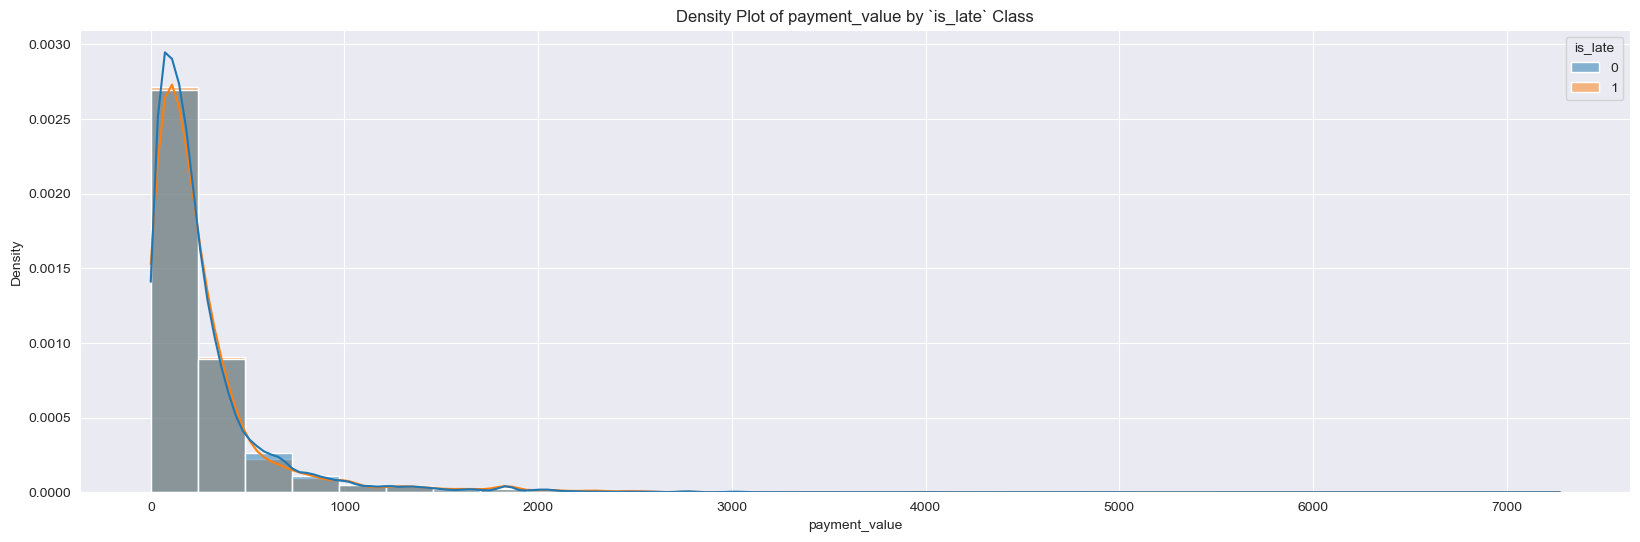

In [42]:
# Histogram with density plot
plt.figure(figsize=(20, 6))
sns.histplot(data=df, x='payment_value', hue='is_late', kde=True, stat='density', common_norm=False, bins=30)
plt.xlabel('payment_value')
plt.ylabel('Density')
plt.title('Density Plot of payment_value by `is_late` Class')
plt.grid(True)
plt.show()

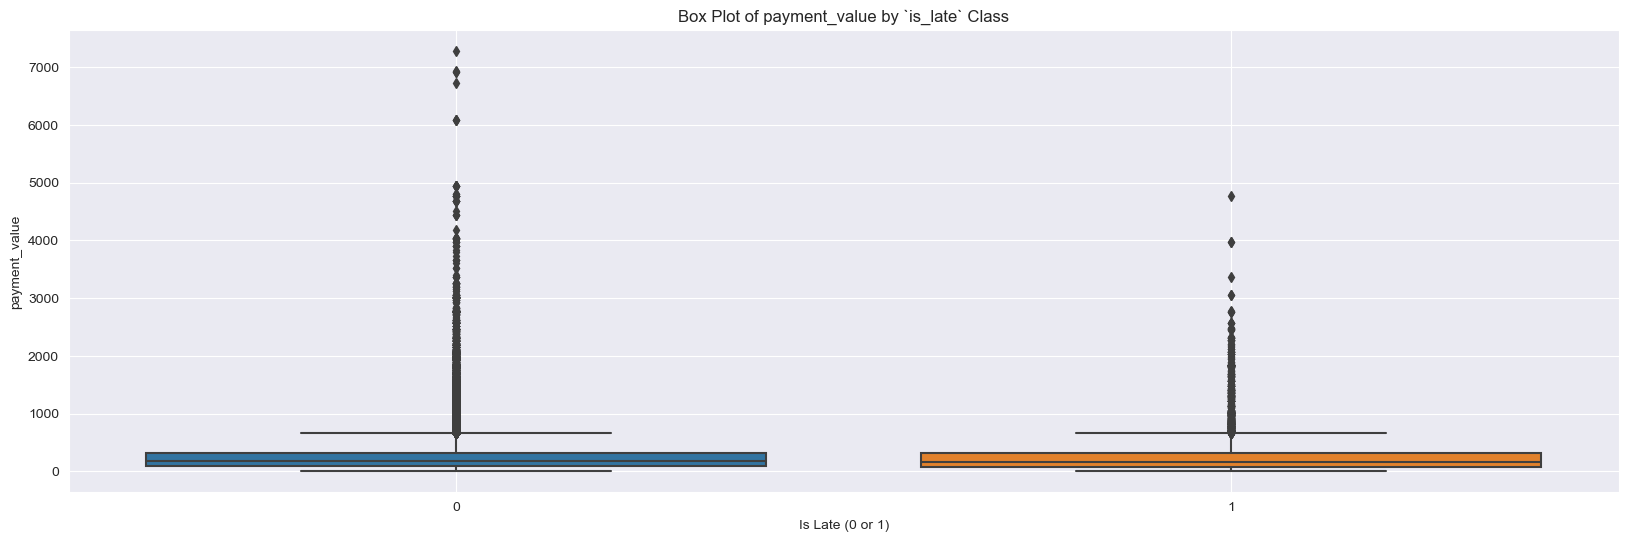

In [43]:
# Box plot to show distribution and outliers
plt.figure(figsize=(20, 6))
sns.boxplot(x='is_late', y='payment_value', data=df)
plt.xlabel('Is Late (0 or 1)')
plt.ylabel('payment_value')
plt.title('Box Plot of payment_value by `is_late` Class')
plt.grid(True)
plt.show()

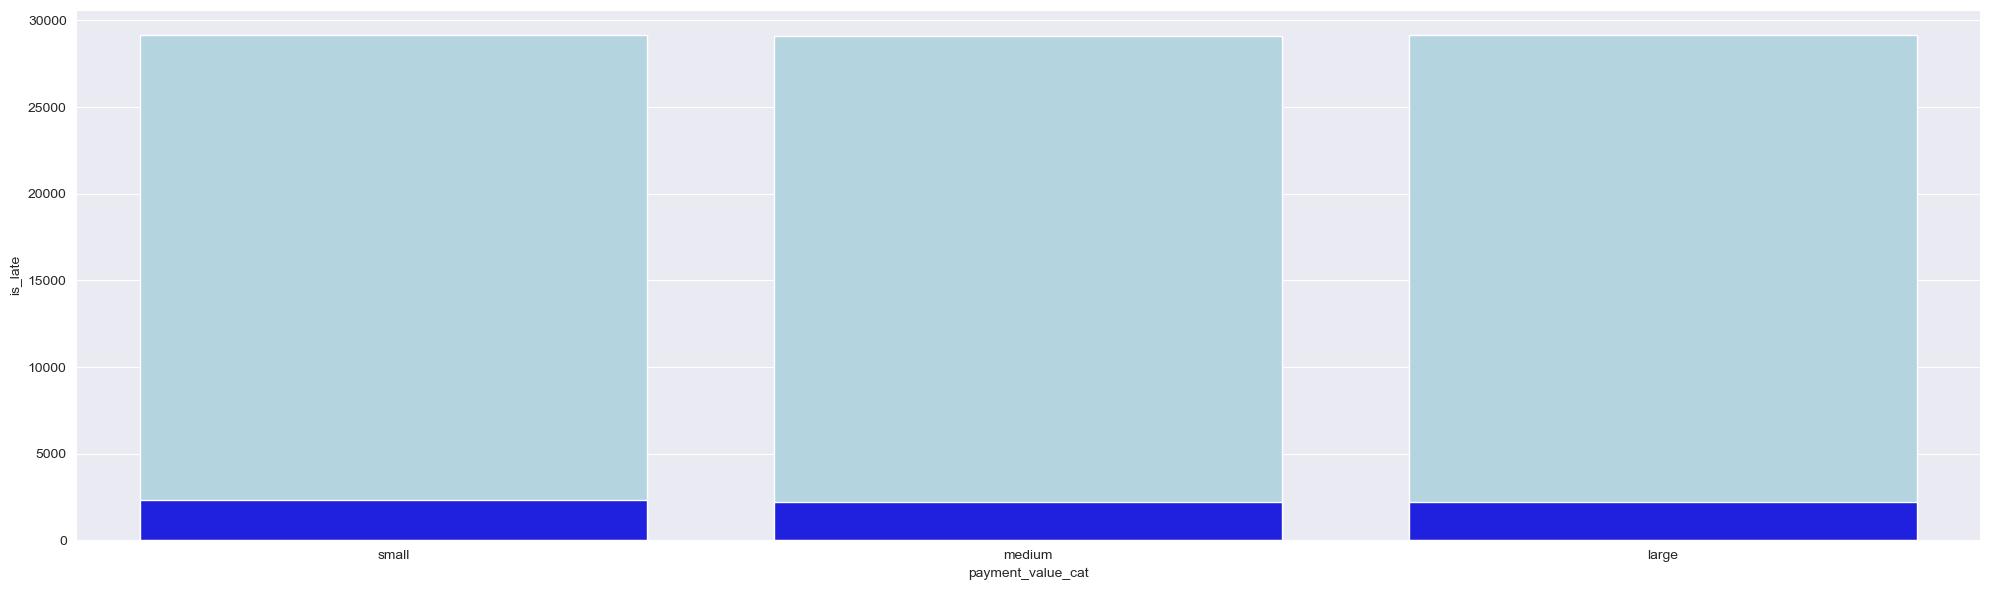

In [44]:
df['payment_value_cat'] = pd.qcut(df['payment_value'], q=3, labels=['small', 'medium', 'large'])

tmp = df[['payment_value_cat', 'is_late']].groupby('payment_value_cat').agg(
    is_late=('is_late', 'sum'),
    count=('payment_value_cat', 'size')
).sort_values(by='is_late', ascending=False).reset_index()
plt.figure(figsize=(20, 6))
sns.barplot(tmp, x='payment_value_cat', y='count', color='lightblue')
sns.barplot(tmp, x='payment_value_cat', y='is_late', color='blue')

plt.tight_layout()
plt.show()

### Feature Selection

In [45]:
df = df.set_index('order_id')

In [46]:
df_final = pd.DataFrame(index=df.index)
df_final['purchase_month'] = df['order_purchase_timestamp'].dt.month
df_final['purchase_hour'] = df['order_purchase_timestamp'].dt.hour

df_final['approve_month'] = df['order_approved_at'].dt.month
df_final['approve_hour'] = df['order_approved_at'].dt.hour

df_final['delivered_month'] = df['order_delivered_timestamp'].dt.month
df_final['delivered_date'] = df['order_delivered_timestamp'].dt.days_in_month
df_final['delivered_hour'] = df['order_delivered_timestamp'].dt.hour

df_final['estimated_month'] = df['order_estimated_delivery_date'].dt.month
df_final['estimated_date'] = df['order_estimated_delivery_date'].dt.days_in_month

df_final['approve_estimated_diff'] = df['approve_estimated_diff']
df_final['purchase_approve_diff'] = df['purchase_approve_diff']

df_final['seller_id'] = df['seller_id']

df_final['customer_zip_code_prefix'] = df['customer_zip_code_prefix']
df_final['customer_city'] = df['customer_city']
df_final['customer_state'] = df['customer_state']

df_final['product_category_name'] = df['product_category_name']

df_final['payment_sequential'] = df['payment_sequential']

df_final['payment_type'] = df['payment_type']
df_final['payment_sequential'] = df['payment_sequential']
df_final['payment_installments'] = df['payment_installments']
df_final['is_late'] = df['is_late']


print(df_final.columns)
df_final.head(2)

Index(['purchase_month', 'purchase_hour', 'approve_month', 'approve_hour',
       'delivered_month', 'delivered_date', 'delivered_hour',
       'estimated_month', 'estimated_date', 'approve_estimated_diff',
       'purchase_approve_diff', 'seller_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'product_category_name',
       'payment_sequential', 'payment_type', 'payment_installments',
       'is_late'],
      dtype='object')


,purchase_month,purchase_hour,approve_month,approve_hour,delivered_month,delivered_date,delivered_hour,estimated_month,estimated_date,approve_estimated_diff,purchase_approve_diff,seller_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name,payment_sequential,payment_type,payment_installments,is_late
order_id,,,,,,,,,,,,,,,,,,,,
Axfy13Hk4PIk,10,18,10,19,10,31,22,11,30,17.198461,0.011331,ZWM05J9LcBSF,58125,varzea paulista,SP,toys,1,credit_card,1,0
v6px92oS8cLG,6,21,6,22,7,31,22,7,31,33.069213,0.027650,IjlpYfhUbRQs,3112,armacao dos buzios,RJ,watches_gifts,1,credit_card,8,0


In [47]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87413 entries, Axfy13Hk4PIk to Xo1fqyXOC6CR
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   purchase_month            87413 non-null  int32  
 1   purchase_hour             87413 non-null  int32  
 2   approve_month             87413 non-null  int32  
 3   approve_hour              87413 non-null  int32  
 4   delivered_month           87413 non-null  int32  
 5   delivered_date            87413 non-null  int32  
 6   delivered_hour            87413 non-null  int32  
 7   estimated_month           87413 non-null  int32  
 8   estimated_date            87413 non-null  int32  
 9   approve_estimated_diff    87413 non-null  float64
 10  purchase_approve_diff     87413 non-null  float64
 11  seller_id                 87413 non-null  object 
 12  customer_zip_code_prefix  87413 non-null  int64  
 13  customer_city             87413 non-null  object

In [48]:
cat_cols = [col for col in df_final.columns if df_final[col].dtype == 'object']
cat_cols

['seller_id',
 'customer_city',
 'customer_state',
 'product_category_name',
 'payment_type']

In [49]:
# Using Label encoder to transform categorical variables

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Iterate over each categorical column and apply LabelEncoder
for col in cat_cols:
    df_final[col] = label_encoder.fit_transform(df_final[col])

# The categorical columns are now encoded as numeric values.
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87413 entries, Axfy13Hk4PIk to Xo1fqyXOC6CR
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   purchase_month            87413 non-null  int32  
 1   purchase_hour             87413 non-null  int32  
 2   approve_month             87413 non-null  int32  
 3   approve_hour              87413 non-null  int32  
 4   delivered_month           87413 non-null  int32  
 5   delivered_date            87413 non-null  int32  
 6   delivered_hour            87413 non-null  int32  
 7   estimated_month           87413 non-null  int32  
 8   estimated_date            87413 non-null  int32  
 9   approve_estimated_diff    87413 non-null  float64
 10  purchase_approve_diff     87413 non-null  float64
 11  seller_id                 87413 non-null  int32  
 12  customer_zip_code_prefix  87413 non-null  int64  
 13  customer_city             87413 non-null  int32 

In [52]:
x = df_final.iloc[:, :-1]
y = df_final.iloc[:, -1]

# Scaling
x = StandardScaler().fit_transform(x)

# Splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Define classifiers and their respective search spaces for hyperparameters
classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'C': Real(1e-6, 1e+6, prior='log-uniform'),
            'solver': ['liblinear']
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': Integer(1, 30),
            'leaf_size': Integer(10, 100)
        }
    },
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': Integer(1, 32),
            'min_samples_split': Integer(2, 20)
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': Integer(10, 100),
            'max_depth': Integer(1, 32),
            'min_samples_split': Integer(2, 20)
        }
    }
}

# Loop through classifiers and perform Bayesian optimization
best_estimators = {}

for clf_name, clf_info in classifiers.items():
    print(f"Optimizing {clf_name}...")
    
    # Initialize BayesSearchCV with the classifier and the search space
    opt = BayesSearchCV(
        estimator=clf_info['model'],
        search_spaces=clf_info['params'],
        n_iter=32,  # Number of parameter settings that are sampled
        cv=5,  # 5-fold cross-validation
        n_jobs=-1,
        random_state=42
    )
    
    # Fit the model with Bayesian optimization
    opt.fit(x_train, y_train)
    
    # Store the best estimator
    best_estimators[clf_name] = opt.best_estimator_
    print(f"Best parameters for {clf_name}: {opt.best_params_}")
    print(f"Best cross-validation score for {clf_name}: {opt.best_score_}\n")

# Make predictions using the optimized models
for clf_name, clf in best_estimators.items():
    print(f"Evaluating {clf_name}...")
    y_pred = clf.predict(x_test)
    
    # Calculate and print the F1 score for the test set
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"F1 score for {clf_name} on the test set: {f1:.4f}\n")


Optimizing LogisticRegression...
Best parameters for LogisticRegression: OrderedDict([('C', 0.08341564384216595), ('solver', 'liblinear')])
Best cross-validation score for LogisticRegression: 0.9226798226798227

Optimizing KNeighborsClassifier...
Best parameters for KNeighborsClassifier: OrderedDict([('leaf_size', 83), ('n_neighbors', 6)])
Best cross-validation score for KNeighborsClassifier: 0.9262119262119262

Optimizing DecisionTreeClassifier...
Best parameters for DecisionTreeClassifier: OrderedDict([('max_depth', 11), ('min_samples_split', 2)])
Best cross-validation score for DecisionTreeClassifier: 0.9397683397683398

Optimizing RandomForestClassifier...
Best parameters for RandomForestClassifier: OrderedDict([('max_depth', 29), ('min_samples_split', 2), ('n_estimators', 100)])
Best cross-validation score for RandomForestClassifier: 0.9511225511225512

Evaluating LogisticRegression...
F1 score for LogisticRegression on the test set: 0.8878

Evaluating KNeighborsClassifier...
F1 s

* Random Forest gave best f1_score of 0.95